# Mô hình phân loại giới tính

# 1. Import dữ liệu huấn luyện, API và ảnh minh họa

#### Notebook này sẽ import 3 bộ dữ liệu, đó là bộ dữ liệu huấn luyện được đề bài cung cấp, bộ dữ liệu chứa ảnh minh họa quá trình kiểm thử (illustrations) và bộ dữ liệu chỉ chứa duy nhất file "kaggle.json" để cài đặt kaggle API.

#### Link dataset chứa file json: https://www.kaggle.com/datasets/minhius/illustrations
#### Link dataset illustrations: https://www.kaggle.com/datasets/minhius/kaggle

In [1]:
import torch
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
import os
from torchvision import datasets
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import random
from glob import glob
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import numpy as np

## Cài đặt kaggle API

In [2]:
os.makedirs('/root/.kaggle/', exist_ok=True)

dataset_json_path = '/kaggle/input/kaggle/kaggle.json'

with open(dataset_json_path, 'rb') as f:
    file_content = f.read()

with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(file_content)

os.chmod('/root/.kaggle/kaggle.json', 0o600)

## Thu thập bộ dữ liệu giới tính

In [3]:
!kaggle competitions download -c 2425-ii-ait-3002-1-gender-classification
!unzip 2425-ii-ait-3002-1-gender-classification.zip -d ./gender_data

Archive:  2425-ii-ait-3002-1-gender-classification.zip
  inflating: ./gender_data/Dataset/Test/000067.jpg  
  inflating: ./gender_data/Dataset/Test/000167.jpg  
  inflating: ./gender_data/Dataset/Test/000480.jpg  
  inflating: ./gender_data/Dataset/Test/000488.jpg  
  inflating: ./gender_data/Dataset/Test/000570.jpg  
  inflating: ./gender_data/Dataset/Test/000575.jpg  
  inflating: ./gender_data/Dataset/Test/000782.jpg  
  inflating: ./gender_data/Dataset/Test/000853.jpg  
  inflating: ./gender_data/Dataset/Test/001059.jpg  
  inflating: ./gender_data/Dataset/Test/001109.jpg  
  inflating: ./gender_data/Dataset/Test/001211.jpg  
  inflating: ./gender_data/Dataset/Test/001347.jpg  
  inflating: ./gender_data/Dataset/Test/001570.jpg  
  inflating: ./gender_data/Dataset/Test/001827.jpg  
  inflating: ./gender_data/Dataset/Test/001891.jpg  
  inflating: ./gender_data/Dataset/Test/001916.jpg  
  inflating: ./gender_data/Dataset/Test/001948.jpg  
  inflating: ./gender_data/Dataset/Test/0023

# 2. Bộ dữ liệu huấn luyện

#### Bộ dữ liệu đã được chia sẵn thành 3 tập huấn luyện, đánh giá và kiểm thử.

In [4]:
# Đọc các folder trong bộ dữ liệu
data_path = "/kaggle/working/gender_data/Dataset"
files = os.listdir(data_path)
print("Files in dataset:", files)

Files in dataset: ['Test', 'Val', 'Train']


#### In ra ngẫu nhiên 10 ảnh. Những hình ảnh được cung cấp là dạng RGB, có kích thước (218, 178, 3), thuộc hai nhãn là Male và Female, đa dạng về góc chụp, ánh sáng, sắc tộc, màu da và phong phú các đặc điểm nhận diện.

Image 1 | Class: Female | Shape: (218, 178, 3)
Image 2 | Class: Male | Shape: (218, 178, 3)
Image 3 | Class: Female | Shape: (218, 178, 3)
Image 4 | Class: Male | Shape: (218, 178, 3)
Image 5 | Class: Male | Shape: (218, 178, 3)
Image 6 | Class: Female | Shape: (218, 178, 3)
Image 7 | Class: Female | Shape: (218, 178, 3)
Image 8 | Class: Female | Shape: (218, 178, 3)
Image 9 | Class: Male | Shape: (218, 178, 3)
Image 10 | Class: Female | Shape: (218, 178, 3)


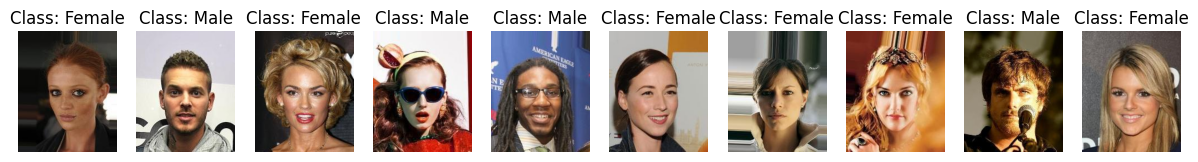

In [5]:
dataset_path = "/kaggle/working/gender_data/Dataset/Train"

image_files = glob(os.path.join(dataset_path, "*/*.jpg")) 

# Lấy ngẫu nhiên 10 ảnh để in ra
num_images = 10
selected_images = random.sample(image_files, num_images)

# Plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    class_name = os.path.basename(os.path.dirname(img_path))  # Trích xuất lớp dữ liệu

    print(f"Image {i+1} | Class: {class_name} | Shape: {img.shape}")  # Lớp và kích thước

    # In
    axes[i].imshow(img)  
    axes[i].set_title(f"Class: {class_name}") 
    axes[i].axis("off")

plt.show()

# 3. Mô hình và xử lý dữ liệu

## Xử lý dữ liệu
#### Em đã sử dụng hai hàm transform riêng biệt cho tập huấn luyện và tập đánh giá/kiểm thử. Với dữ liệu huấn luyện, ngoài các biến đổi cơ bản như điều chỉnh kích thước, chuyển thành tensor và chuẩn hóa giá trị, em còn áp dụng thêm các phương pháp augmentation như điều chỉnh ánh sáng (color jitter), lật chiều ngang và xoay ngẫu nhiên (-10 độ hoặc 10 độ) để mô hình tổng quát hóa tốt hơn.

#### Đối với dữ liệu đánh giá và kiểm thử, em không áp dụng augmentation và phần còn lại giống với hàm trên.

In [6]:
train_transform = transforms.Compose([
    transforms.ColorJitter(
    brightness=0.2,
    contrast=0.2,
    saturation=0.2,
    hue=0.1
    ),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#### Sau một số lần chạy thử nghiệm, em đã rút ra được giá trị batch bằng 64 là tối ưu nhất trong việc tận dụng toàn bộ tài nguyên tính toán được cung cấp bởi Kaggle. Bộ dữ liệu huấn luyện sẽ được tráo khi sử dụng bởi kết quả chạy những lượt đầu cho thấy mô hình sẽ underfit nghiêm trọng do học tuần tự.

In [7]:
batch_size = 64

train_dir = "/kaggle/working/gender_data/Dataset/Train"
val_dir = "/kaggle/working/gender_data/Dataset/Val"

train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
train_dataset.class_to_idx = {'Male': 0, 'Female': 1}
val_dataset.class_to_idx = {'Male': 0, 'Female': 1}

# Seed
seed = 2004
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Những thử nghiệm đầu về mô hình
#### Em đã nghiên cứu và xác định sẽ cần sử dụng một trong những kiến trúc CNN tiên tiến có khả năng trích xuất nhiều tầng đặc trưng có hệ thống, đồng thời đảm bảo tốc độ học, lượng tiêu hao tài nguyên và không quá phức tạp. ResNet là một kiến trúc phù hợp cho yêu cầu đề ra, và cụ thể em đã thử nghiệm giữa ResNet18 và ResNet34 để chọn ra kiến trúc tốt nhất (ResNet50 rất sâu và quá mạnh nên em sẽ không lựa chọn để so sánh). Cả hai kiến trúc thí nghiệm đều đã được pretrain trên tập ImageNet1k_V1 và em đã thêm một lớp dropout với tỉ lệ 50% để cải thiện overfit.

| Layer Name | Output Size      | ResNet-18         | ResNet-34                 |
|------------|------------------|-------------------|---------------------------|
| Conv1      | 112×112          | 7×7, 64, stride 2 | 7×7, 64, stride 2         |
|            |                  | MaxPool 3×3, s=2  | MaxPool 3×3, s=2          |
| Conv2_x    | 56×56            | [3×3, 64] × 2     | [3×3, 64] × 3             |
| Conv3_x    | 28×28            | [3×3, 128] × 2    | [3×3, 128] × 4            |
| Conv4_x    | 14×14            | [3×3, 256] × 2    | [3×3, 256] × 6            |
| Conv5_x    | 7×7              | [3×3, 512] × 2    | [3×3, 512] × 3            |
| AvgPool    | 1×1              | Global Avg Pool   | Global Avg Pool           |
| Dropout    | 1×1              | Dropout(p=0.5)    | Dropout(p=0.5)            |
| FC         | 1×1              | 2-d FC            | 2-d FC                    |
| **FLOPs**  | –                | **1.8 GFLOPs**    | **3.6 GFLOPs**            |

## Minh họa hai kiến trúc gốc của ResNet18 và ResNet34

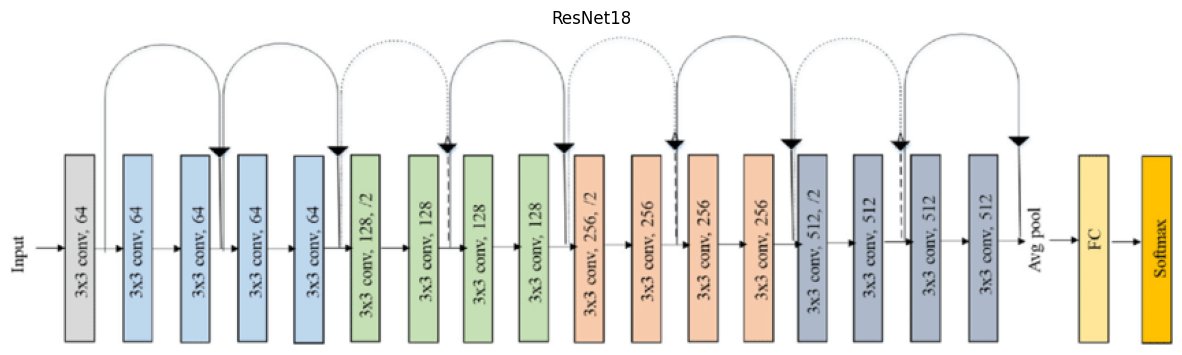

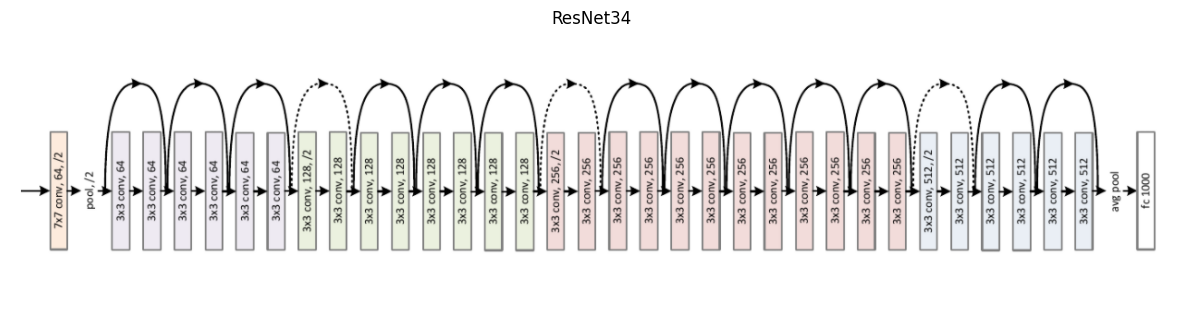

In [8]:
#ResNet18
plt.figure(figsize=(15, 15))
compare18 = Image.open('/kaggle/input/illustrations/18.png')
plt.imshow(compare18)
plt.title("ResNet18")
plt.axis('off')
plt.show()

#ResNet34
plt.figure(figsize=(15, 15))
compare34 = Image.open('/kaggle/input/illustrations/34.png')
plt.imshow(compare34)
plt.title("ResNet34")
plt.axis('off')
plt.show()

## So sánh ResNet18 và ResNet34.
#### Quá trình thử nghiệm bắt đầu trước với ResNet34 cùng với những setup cơ bản (augmentation chỉ có lật và xoay ảnh). Trong những lần huấn luyện đầu mô hình overfit rất nặng nên em đã tinh chỉnh tốc độ học, thêm phân rã trọng số, thêm dropout. Các giá trị learning rate (LR) được thử là 2e-05, 1e-05, 2e-06, 1e-06, 9.9e-07, 9.7e-07, 9.5e-07 với những giá trị epoch phù hợp. Early stopping cũng được áp dụng để tránh overfit về cuối.

#### Tại giá trị LR = 9.5e-07, ResNet34 đạt độ chính xác 0.9833 trên tập kiểm thử sau 100 epochs. Color Jitter được bổ sung vào hàm transform của tập huấn luyện để xử lý độ chênh lệch ánh sáng giữa các ảnh, giúp mô hình tập trung hơn vào các đặc trưng hình thể của mỗi giới. Cho dù có sự thay đổi, mô hình vẫn đạt ngưỡng cao nhất là 0.9833, và chững lại ở mốc này dù đã có thử nghiệm nhiều hơn. Dưới đây là tham số tối ưu của ResNet34:
#### - LR = 9.5e-07
#### - Epoch = 100
#### - Weight decay = 1e-8
#### - Dropout = 50%
#### - Early stopping, patience = 10
#### - Batch = 64

#### ResNet34 đã đạt tới ngưỡng học nên tiếp theo thử nghiệm với ResNet18, em đã cho chạy với cùng bộ tham số tốt nhất của ResNet34 và đã cho ra kết quả tốt hơn mô hình trước, ở mức 0.9866. Khi so sánh biểu đồ mất mát, ResNet34 cho thấy dấu hiệu overfit nhiều hơn ResNet18 ở giai đoạn cuối, nghĩa là ResNet34 đang quá mạnh khiến cho tinh chỉnh gặp khó khăn và mô hình khó học được ở giai đoạn cuối. Nếu muốn vượt qua được thì cần giá trị LR rất nhỏ và tăng thêm khá nhiều epoch dẫn tới thời gian chạy lâu - điều mà có thể khắc phục bằng cách giảm độ sâu mô hình. Em quyết định sẽ sử dụng ResNet18 với hiệu năng tốt hơn mà thời gian huấn luyện nhanh hơn 1.5 lần.

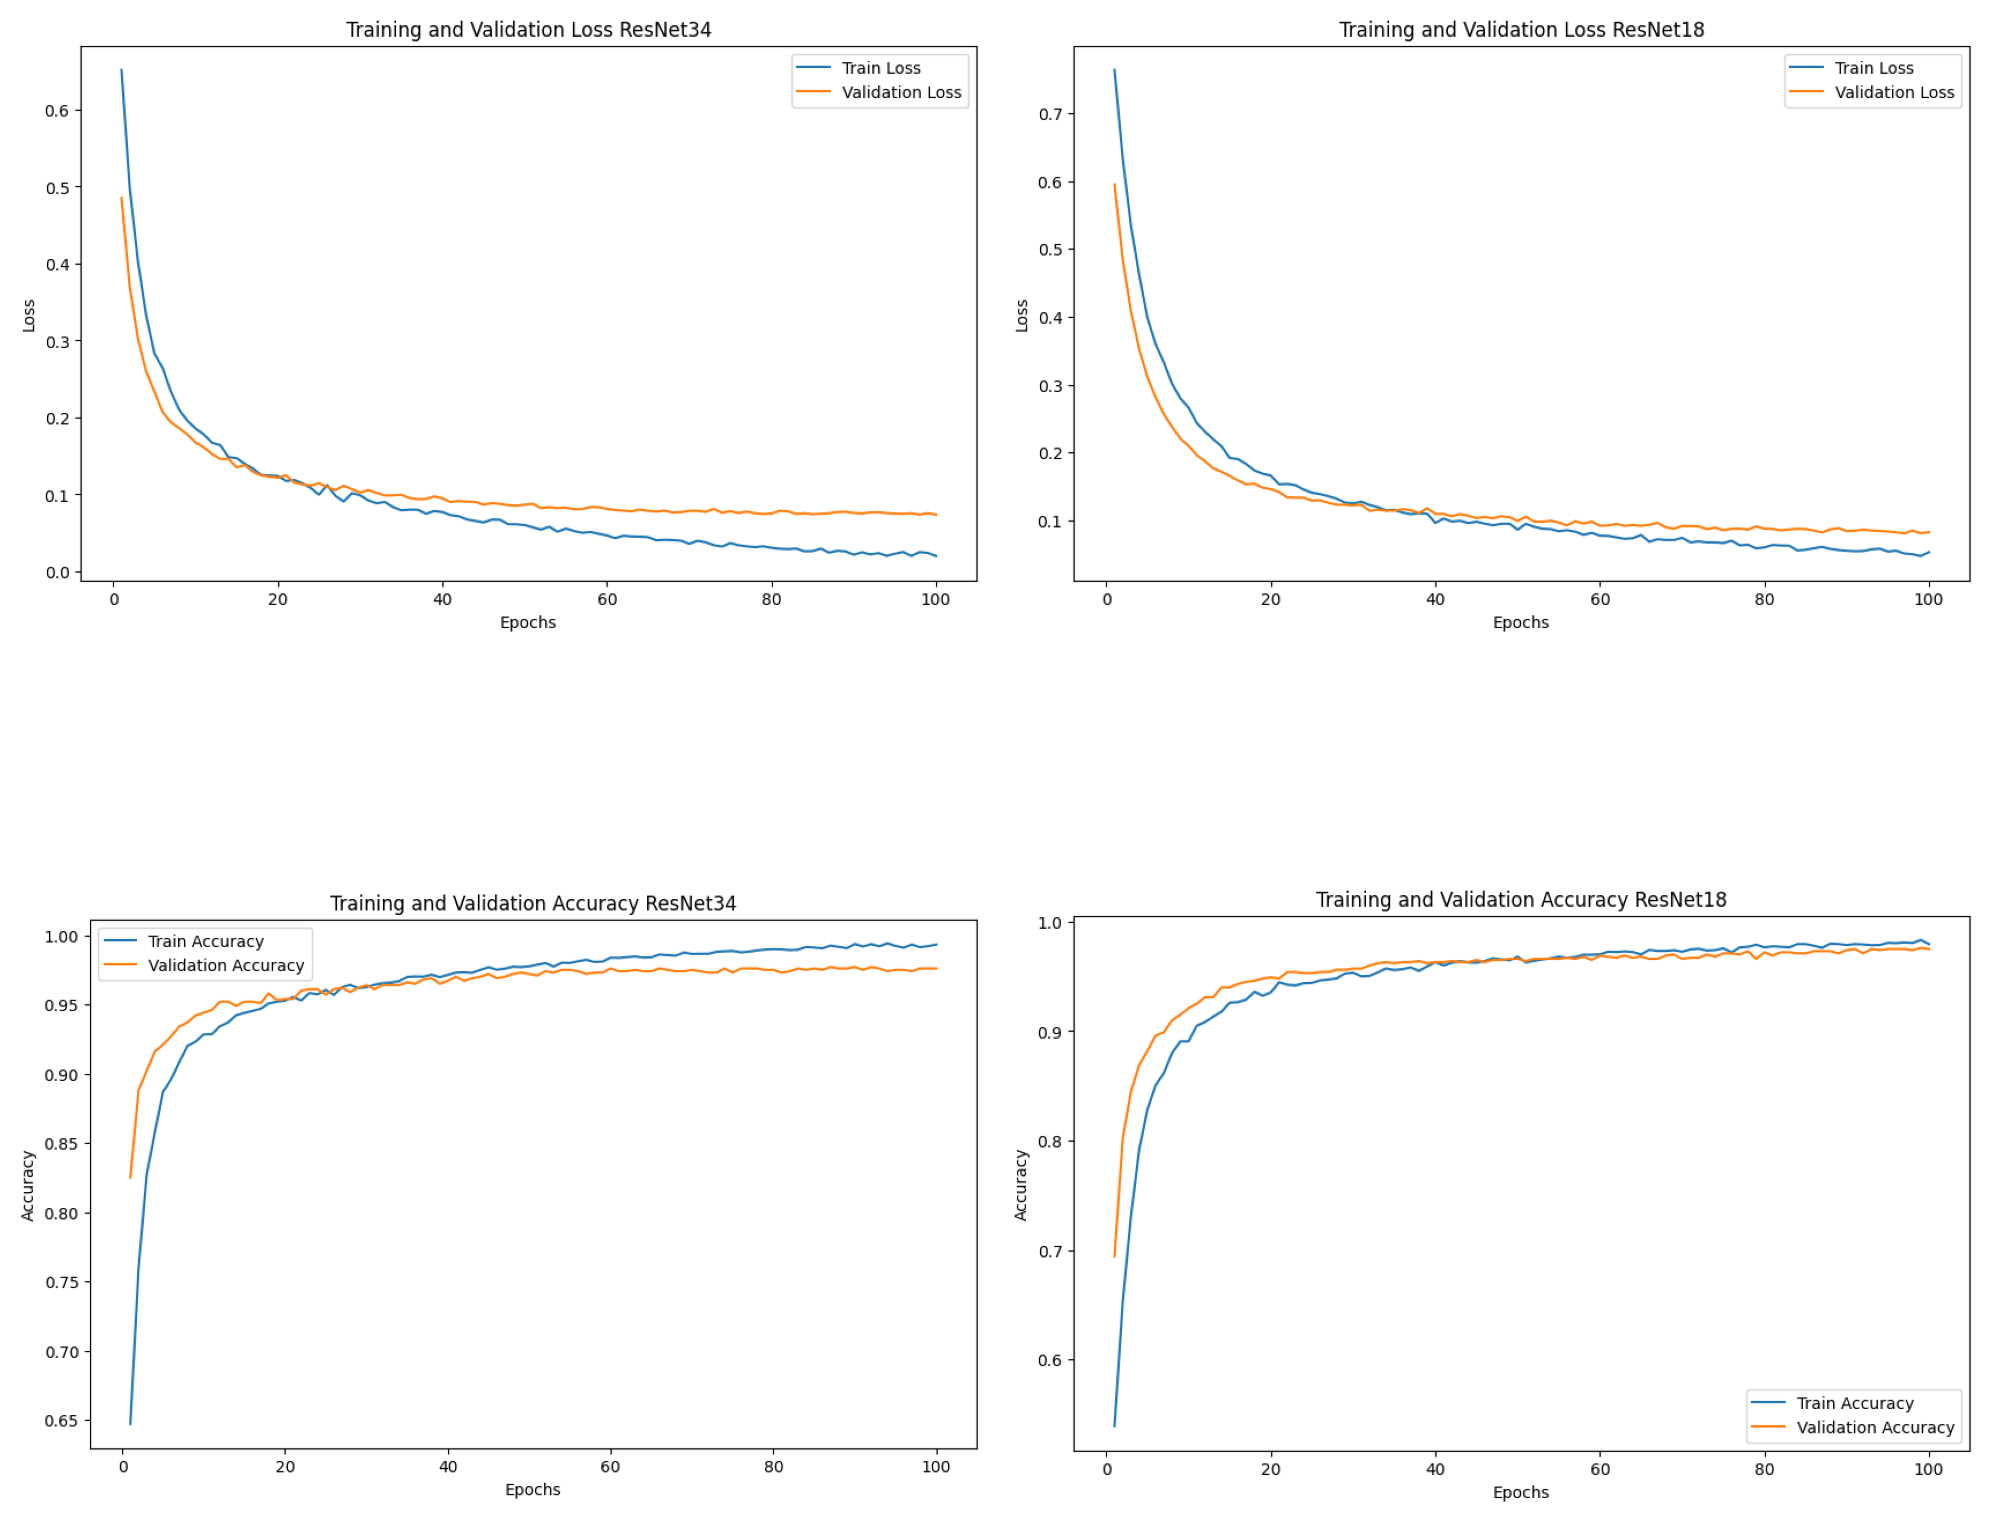

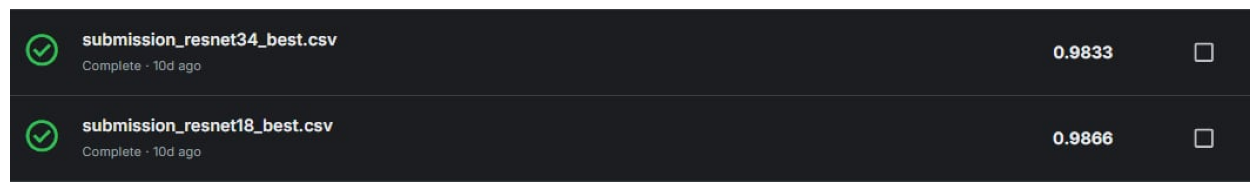

In [9]:
img_paths = [
    '/kaggle/input/illustrations/res34_loss.png',
    '/kaggle/input/illustrations/res18_loss.png',
    '/kaggle/input/illustrations/res34_acc.png',
    '/kaggle/input/illustrations/res18_acc.png'
]

images = [Image.open(p) for p in img_paths]

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()

for ax, img, i in zip(axes, images, range(1, 5)):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Kết quả submit
plt.figure(figsize=(16, 14)) 
compare = Image.open('/kaggle/input/illustrations/submit_compare_18_34.jfif')
plt.imshow(compare)
plt.axis('off')
plt.show()

In [10]:
num_classes = 2 
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # Mô hình phù hợp nhất
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


# 4. Huấn luyện.

## Tinh chỉnh ResNet18
#### Ý tưởng của những thử nghệm tiếp theo là hạ LR, tăng phân ra trọng số và tăng epoch để mô hình có thể đạt được hiệu suất tốt hơn mốc 0.9866. Sau một vài lần chạy thì kết quả không có tiến triển, thậm chí còn có những lần hiệu suất giảm. Nhưng đáng chú ý là trên biểu đồ mất mát, mô hình vẫn cho thấy dấu hiệu overfit vào giai đoạn cuối, dù ít hơn ResNet34 nhưng vẫn có. Lý do là LR khi đó chưa đủ nhỏ để mô hình học một cách ổn định, dẫn đến đường đồ thị dao động. Để khắc phục vấn đề này, em đã tìm hiểu và thử nghiệm hai loại scheduler là StepLR và CosineAnnealing. Những thử nghiệm cho thấy Cosine Annealing có đặc tính và cách xử lý LR tốt hơn StepLR khi nó có thể thích nghi với số epoch và cho phép cài đặt mốc LR nhỏ nhất mong muốn. Cuối cùng, sau khoảng 3 lần chạy với scheduler, với bộ tham số:
#### - LR = 9.3e-07
#### - Epoch = 180
#### - Min LR = 1e-9
#### - Weight decay = 5e-9
#### - Dropout = 50%
#### - Early stopping, patience = 10
#### - Batch = 64

#### thì ResNet18 đã đạt được hiệu suất tốt nhất đến hiện tại là 0.99. Em đã tiếp tục thử nghiệm với nhiều tổ hợp siêu tham số khác nhau, tuy nhiên mô hình không đạt được hiệu suất cao hơn mốc 0.99. Do đó, em quyết định dừng quá trình tinh chỉnh tại ngưỡng này.

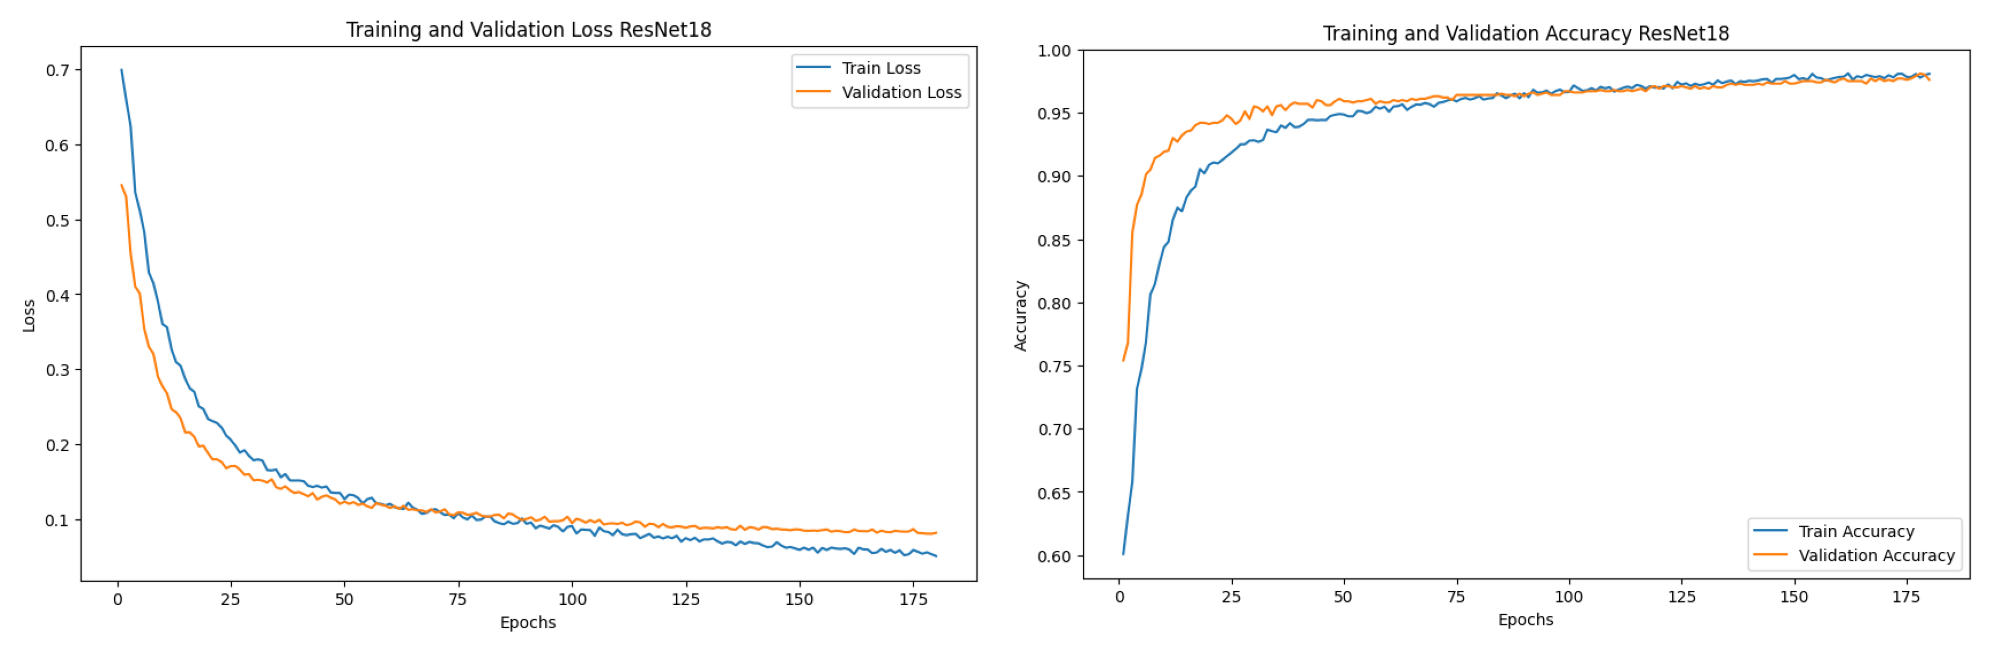

In [11]:
# Kết quả tốt nhất của ResNet18 - biểu đồ
img_paths = [
    '/kaggle/input/illustrations/18_best_loss.png',
    '/kaggle/input/illustrations/18_best_acc.png'
]

images = [Image.open(p) for p in img_paths]

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes = axes.flatten()

for ax, img, i in zip(axes, images, range(1, 5)):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

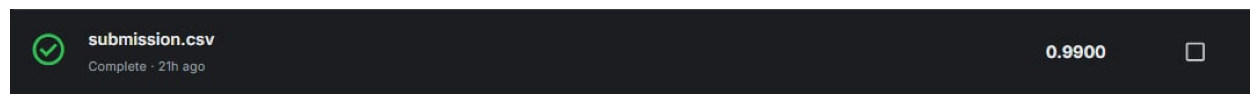

In [12]:
# Kết quả tốt nhất của ResNet18 - 0.99
plt.figure(figsize=(16, 14)) 
compare3 = Image.open('/kaggle/input/illustrations/submit_18_best.jfif')
plt.imshow(compare3)
plt.axis('off')
plt.show()

#### Giá trị phân rã được chọn thông qua nhiều thử nghiệm, vì ở những epoch cuối, LR đã rất nhỏ, khiến mô hình học rất chậm. Do đó, hệ số phân rã trọng số (weight decay) không nên quá lớn, nếu không sẽ làm giảm khả năng học của mô hình.

In [13]:
LR = 9.3e-07
EPOCHS = 180
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-9)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=180, eta_min=1e-9)
device = "cuda"

In [14]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
def train(model, train_loader, optimizer, criterion, device, scheduler):
    total_correct = 0.0
    total_loss = 0.0
    batch_loss = 0.0
    batch_correct = 0.0

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        output = model(inputs) 
        
        # Tính loss
        loss = criterion(output, labels)
        loss.backward()
        
        # Tính accuracy
        correct = (output.argmax(dim=1) == labels).sum().item()
        
        # Tích lũy loss và accuracy
        total_correct += correct
        total_loss += loss.item()

        # Thống kê theo batch
        batch_correct += correct
        batch_loss += loss.item()

        optimizer.step()
        
        # In độ chính xác và mất mát trung bình mỗi epoch (125 batch x 64 size = 8000 input)
        if (idx + 1) % 125 == 0:
            print(f"EPOCH: Average Loss {batch_loss / 125:.4f} | Average Accuracy {batch_correct / (125 * len(labels)) * 100:.2f}%")
            batch_correct = 0.0
            batch_loss = 0.0

        scheduler.step()
    
    # Trả về trung bình mất mát và chính xác
    avg_accuracy = total_correct / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)
    return avg_accuracy, avg_loss

In [16]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_correct = 0.0
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            
            # Tính loss
            loss = criterion(output, labels)
            total_correct += (output.argmax(dim=1) == labels).sum().item()
            total_loss += loss.item()

    accuracy = total_correct / len(loader.dataset)
    loss = total_loss / len(loader)
    
    return accuracy, loss

#### Những dữ liệu sẽ được theo dõi xuyên suốt quá trình chạy là độ chính xác và mất mát trung bình, độ chính xác và mất mát của hai tập huấn luyện và đánh giá trên từng epoch.

In [17]:
def run(model, train_loader, validation_loader, optimizer, criterion, device, scheduler):
    current_patience = 0
    previous_valid_loss = None
    best_valid_loss = None
    
    # List để lưu trữ loss và accuracy để plot
    train_losses = []
    valid_losses = []
    train_acc = []
    val_acc = []
    
    # In ra kết quả huấn luyện mỗi epoch
    for epoch in tqdm(range(EPOCHS)):
        print("==================================================")
        print(f"EPOCH {epoch + 1}")
        train_accuracy, train_loss = train(model, train_loader, optimizer, criterion, device, scheduler)
        print(f"[TRAIN] EPOCH {epoch + 1} - LOSS: {train_loss}, ACCURACY: {train_accuracy}")
        validation_accuracy, validation_loss = evaluate(model, val_loader, criterion, device)
        print(f"[VALIDATE] EPOCH {epoch + 1} - LOSS: {validation_loss}, ACCURACY: {validation_accuracy}")

        # Lưu trữ loss và accuracy
        train_losses.append(train_loss)
        valid_losses.append(validation_loss)
        train_acc.append(train_accuracy)
        val_acc.append(validation_accuracy)

        # Lấy val loss epoch đầu làm chuẩn
        if best_valid_loss is None and previous_valid_loss is None:
            best_valid_loss = validation_loss
            previous_valid_loss = validation_loss
            continue
            
        # Early stopping nếu loss không tiến triển 10 epoch liên tiếp.
        if validation_loss >= previous_valid_loss:
            current_patience += 1
            if current_patience >= 10:
                print("Early Stop")
                break
            previous_valid_loss = validation_loss

        # Lưu model tốt nhất
        if validation_loss <= best_valid_loss:
            torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            best_valid_loss = validation_loss
            patience = 0

    # Plot loss 
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss ResNet18')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy ResNet18')
    plt.legend()
    plt.show()

    # Lưu model chạy hết số epoch
    torch.save(model.state_dict(), '/kaggle/working/last_epoch_model.pth')

  0%|          | 0/180 [00:00<?, ?it/s]

EPOCH 1
EPOCH: Average Loss 0.8068 | Average Accuracy 53.79%
[TRAIN] EPOCH 1 - LOSS: 0.8067979855537415, ACCURACY: 0.537875


  1%|          | 1/180 [00:30<1:32:09, 30.89s/it]

[VALIDATE] EPOCH 1 - LOSS: 0.6984320804476738, ACCURACY: 0.549
EPOCH 2
EPOCH: Average Loss 0.7705 | Average Accuracy 56.15%
[TRAIN] EPOCH 2 - LOSS: 0.7704653720855713, ACCURACY: 0.5615


  1%|          | 2/180 [01:00<1:29:46, 30.26s/it]

[VALIDATE] EPOCH 2 - LOSS: 0.6840679571032524, ACCURACY: 0.557
EPOCH 3
EPOCH: Average Loss 0.7152 | Average Accuracy 59.75%
[TRAIN] EPOCH 3 - LOSS: 0.7152325420379638, ACCURACY: 0.5975


  2%|▏         | 3/180 [01:30<1:29:12, 30.24s/it]

[VALIDATE] EPOCH 3 - LOSS: 0.5837386297062039, ACCURACY: 0.628
EPOCH 4
EPOCH: Average Loss 0.6179 | Average Accuracy 65.94%
[TRAIN] EPOCH 4 - LOSS: 0.6179036309719086, ACCURACY: 0.659375


  2%|▏         | 4/180 [02:01<1:28:56, 30.32s/it]

[VALIDATE] EPOCH 4 - LOSS: 0.5150295421481133, ACCURACY: 0.726
EPOCH 5
EPOCH: Average Loss 0.5982 | Average Accuracy 67.75%
[TRAIN] EPOCH 5 - LOSS: 0.5982032928466797, ACCURACY: 0.6775


  3%|▎         | 5/180 [02:32<1:29:01, 30.52s/it]

[VALIDATE] EPOCH 5 - LOSS: 0.5025278143584728, ACCURACY: 0.74
EPOCH 6
EPOCH: Average Loss 0.5483 | Average Accuracy 71.54%
[TRAIN] EPOCH 6 - LOSS: 0.5482769479751587, ACCURACY: 0.715375


  3%|▎         | 6/180 [03:03<1:29:10, 30.75s/it]

[VALIDATE] EPOCH 6 - LOSS: 0.43875506427139044, ACCURACY: 0.811
EPOCH 7
EPOCH: Average Loss 0.4985 | Average Accuracy 75.50%
[TRAIN] EPOCH 7 - LOSS: 0.49853834342956543, ACCURACY: 0.755


  4%|▍         | 7/180 [03:34<1:29:11, 30.93s/it]

[VALIDATE] EPOCH 7 - LOSS: 0.4026627568528056, ACCURACY: 0.842
EPOCH 8
EPOCH: Average Loss 0.4853 | Average Accuracy 76.11%
[TRAIN] EPOCH 8 - LOSS: 0.4852669529914856, ACCURACY: 0.761125


  4%|▍         | 8/180 [04:05<1:28:54, 31.01s/it]

[VALIDATE] EPOCH 8 - LOSS: 0.3988975649699569, ACCURACY: 0.841
EPOCH 9
EPOCH: Average Loss 0.4473 | Average Accuracy 78.79%
[TRAIN] EPOCH 9 - LOSS: 0.4472612729072571, ACCURACY: 0.787875


  5%|▌         | 9/180 [04:36<1:28:24, 31.02s/it]

[VALIDATE] EPOCH 9 - LOSS: 0.3535299338400364, ACCURACY: 0.87
EPOCH 10
EPOCH: Average Loss 0.4044 | Average Accuracy 81.71%
[TRAIN] EPOCH 10 - LOSS: 0.40444008326530456, ACCURACY: 0.817125


  6%|▌         | 10/180 [05:07<1:27:51, 31.01s/it]

[VALIDATE] EPOCH 10 - LOSS: 0.3333421181887388, ACCURACY: 0.886
EPOCH 11
EPOCH: Average Loss 0.3974 | Average Accuracy 82.27%
[TRAIN] EPOCH 11 - LOSS: 0.39740876126289365, ACCURACY: 0.82275


  6%|▌         | 11/180 [05:39<1:27:27, 31.05s/it]

[VALIDATE] EPOCH 11 - LOSS: 0.3240679372102022, ACCURACY: 0.888
EPOCH 12
EPOCH: Average Loss 0.3737 | Average Accuracy 83.84%
[TRAIN] EPOCH 12 - LOSS: 0.3736659133434296, ACCURACY: 0.838375


  7%|▋         | 12/180 [06:10<1:26:59, 31.07s/it]

[VALIDATE] EPOCH 12 - LOSS: 0.29183722101151943, ACCURACY: 0.899
EPOCH 13
EPOCH: Average Loss 0.3512 | Average Accuracy 85.04%
[TRAIN] EPOCH 13 - LOSS: 0.3512493702173233, ACCURACY: 0.850375


  7%|▋         | 13/180 [06:41<1:26:32, 31.09s/it]

[VALIDATE] EPOCH 13 - LOSS: 0.2906323494389653, ACCURACY: 0.897
EPOCH 14
EPOCH: Average Loss 0.3568 | Average Accuracy 84.72%
[TRAIN] EPOCH 14 - LOSS: 0.3567786329984665, ACCURACY: 0.84725


  8%|▊         | 14/180 [07:12<1:26:03, 31.10s/it]

[VALIDATE] EPOCH 14 - LOSS: 0.28040605038404465, ACCURACY: 0.899
EPOCH 15
EPOCH: Average Loss 0.3301 | Average Accuracy 86.08%
[TRAIN] EPOCH 15 - LOSS: 0.3301039310693741, ACCURACY: 0.86075


  8%|▊         | 15/180 [07:43<1:25:44, 31.18s/it]

[VALIDATE] EPOCH 15 - LOSS: 0.256020933855325, ACCURACY: 0.913
EPOCH 16
EPOCH: Average Loss 0.3165 | Average Accuracy 86.74%
[TRAIN] EPOCH 16 - LOSS: 0.31650942146778105, ACCURACY: 0.867375


  9%|▉         | 16/180 [08:15<1:25:21, 31.23s/it]

[VALIDATE] EPOCH 16 - LOSS: 0.2577963238582015, ACCURACY: 0.907
EPOCH 17
EPOCH: Average Loss 0.3035 | Average Accuracy 87.74%
[TRAIN] EPOCH 17 - LOSS: 0.30346652162075044, ACCURACY: 0.877375


  9%|▉         | 17/180 [08:46<1:25:08, 31.34s/it]

[VALIDATE] EPOCH 17 - LOSS: 0.24591287039220333, ACCURACY: 0.914
EPOCH 18
EPOCH: Average Loss 0.2929 | Average Accuracy 87.78%
[TRAIN] EPOCH 18 - LOSS: 0.2929206020832062, ACCURACY: 0.87775


 10%|█         | 18/180 [09:17<1:24:27, 31.28s/it]

[VALIDATE] EPOCH 18 - LOSS: 0.22928499896079302, ACCURACY: 0.915
EPOCH 19
EPOCH: Average Loss 0.2819 | Average Accuracy 88.76%
[TRAIN] EPOCH 19 - LOSS: 0.28192948627471925, ACCURACY: 0.887625


 11%|█         | 19/180 [09:49<1:23:52, 31.26s/it]

[VALIDATE] EPOCH 19 - LOSS: 0.2267305082641542, ACCURACY: 0.917
EPOCH 20
EPOCH: Average Loss 0.2838 | Average Accuracy 88.39%
[TRAIN] EPOCH 20 - LOSS: 0.28378468203544616, ACCURACY: 0.883875


 11%|█         | 20/180 [10:20<1:23:12, 31.20s/it]

[VALIDATE] EPOCH 20 - LOSS: 0.22613752586767077, ACCURACY: 0.915
EPOCH 21
EPOCH: Average Loss 0.2643 | Average Accuracy 89.36%
[TRAIN] EPOCH 21 - LOSS: 0.26428112435340884, ACCURACY: 0.893625


 12%|█▏        | 21/180 [10:51<1:22:46, 31.23s/it]

[VALIDATE] EPOCH 21 - LOSS: 0.2137641552835703, ACCURACY: 0.918
EPOCH 22
EPOCH: Average Loss 0.2578 | Average Accuracy 89.85%
[TRAIN] EPOCH 22 - LOSS: 0.2578318272829056, ACCURACY: 0.8985


 12%|█▏        | 22/180 [11:22<1:22:14, 31.23s/it]

[VALIDATE] EPOCH 22 - LOSS: 0.20780146354809403, ACCURACY: 0.923
EPOCH 23
EPOCH: Average Loss 0.2521 | Average Accuracy 89.65%
[TRAIN] EPOCH 23 - LOSS: 0.25213766169548035, ACCURACY: 0.8965


 13%|█▎        | 23/180 [11:53<1:21:34, 31.18s/it]

[VALIDATE] EPOCH 23 - LOSS: 0.20402055187150836, ACCURACY: 0.924
EPOCH 24
EPOCH: Average Loss 0.2377 | Average Accuracy 90.62%
[TRAIN] EPOCH 24 - LOSS: 0.2376720522046089, ACCURACY: 0.90625


 13%|█▎        | 24/180 [12:24<1:20:51, 31.10s/it]

[VALIDATE] EPOCH 24 - LOSS: 0.19279331900179386, ACCURACY: 0.928
EPOCH 25
EPOCH: Average Loss 0.2314 | Average Accuracy 90.66%
[TRAIN] EPOCH 25 - LOSS: 0.23137752574682235, ACCURACY: 0.906625


 14%|█▍        | 25/180 [12:55<1:20:10, 31.03s/it]

[VALIDATE] EPOCH 25 - LOSS: 0.202544875908643, ACCURACY: 0.923
EPOCH 26
EPOCH: Average Loss 0.2313 | Average Accuracy 91.14%
[TRAIN] EPOCH 26 - LOSS: 0.2313364651799202, ACCURACY: 0.911375


 14%|█▍        | 26/180 [13:26<1:19:53, 31.12s/it]

[VALIDATE] EPOCH 26 - LOSS: 0.18661383632570505, ACCURACY: 0.928
EPOCH 27
EPOCH: Average Loss 0.2224 | Average Accuracy 91.49%
[TRAIN] EPOCH 27 - LOSS: 0.22243557715415954, ACCURACY: 0.914875


 15%|█▌        | 27/180 [13:58<1:19:41, 31.25s/it]

[VALIDATE] EPOCH 27 - LOSS: 0.17831258662045002, ACCURACY: 0.931
EPOCH 28
EPOCH: Average Loss 0.2144 | Average Accuracy 91.51%
[TRAIN] EPOCH 28 - LOSS: 0.2144105694293976, ACCURACY: 0.915125


 16%|█▌        | 28/180 [14:30<1:19:36, 31.42s/it]

[VALIDATE] EPOCH 28 - LOSS: 0.17849286645650864, ACCURACY: 0.932
EPOCH 29
EPOCH: Average Loss 0.2112 | Average Accuracy 91.45%
[TRAIN] EPOCH 29 - LOSS: 0.21120746785402297, ACCURACY: 0.9145


 16%|█▌        | 29/180 [15:01<1:19:14, 31.49s/it]

[VALIDATE] EPOCH 29 - LOSS: 0.1809467643033713, ACCURACY: 0.933
EPOCH 30
EPOCH: Average Loss 0.2019 | Average Accuracy 92.27%
[TRAIN] EPOCH 30 - LOSS: 0.2019468795657158, ACCURACY: 0.92275


 17%|█▋        | 30/180 [15:33<1:18:32, 31.42s/it]

[VALIDATE] EPOCH 30 - LOSS: 0.17757516633719206, ACCURACY: 0.932
EPOCH 31
EPOCH: Average Loss 0.1999 | Average Accuracy 92.27%
[TRAIN] EPOCH 31 - LOSS: 0.19988268977403642, ACCURACY: 0.92275


 17%|█▋        | 31/180 [16:04<1:17:59, 31.40s/it]

[VALIDATE] EPOCH 31 - LOSS: 0.18132005631923676, ACCURACY: 0.932
EPOCH 32
EPOCH: Average Loss 0.1897 | Average Accuracy 92.26%
[TRAIN] EPOCH 32 - LOSS: 0.18967121535539627, ACCURACY: 0.922625


 18%|█▊        | 32/180 [16:36<1:17:36, 31.47s/it]

[VALIDATE] EPOCH 32 - LOSS: 0.1639416953548789, ACCURACY: 0.939
EPOCH 33
EPOCH: Average Loss 0.1870 | Average Accuracy 92.90%
[TRAIN] EPOCH 33 - LOSS: 0.18703647583723068, ACCURACY: 0.929


 18%|█▊        | 33/180 [17:07<1:17:01, 31.44s/it]

[VALIDATE] EPOCH 33 - LOSS: 0.16227198275737464, ACCURACY: 0.94
EPOCH 34
EPOCH: Average Loss 0.1851 | Average Accuracy 92.26%
[TRAIN] EPOCH 34 - LOSS: 0.18512026610970497, ACCURACY: 0.922625


 19%|█▉        | 34/180 [17:38<1:16:21, 31.38s/it]

[VALIDATE] EPOCH 34 - LOSS: 0.16032232926227152, ACCURACY: 0.94
EPOCH 35
EPOCH: Average Loss 0.1811 | Average Accuracy 92.86%
[TRAIN] EPOCH 35 - LOSS: 0.1810907530784607, ACCURACY: 0.928625


 19%|█▉        | 35/180 [18:10<1:15:46, 31.35s/it]

[VALIDATE] EPOCH 35 - LOSS: 0.1585946639534086, ACCURACY: 0.94
EPOCH 36
EPOCH: Average Loss 0.1782 | Average Accuracy 93.12%
[TRAIN] EPOCH 36 - LOSS: 0.1782481769323349, ACCURACY: 0.93125


 20%|██        | 36/180 [18:41<1:15:12, 31.34s/it]

[VALIDATE] EPOCH 36 - LOSS: 0.15782100823707879, ACCURACY: 0.94
EPOCH 37
EPOCH: Average Loss 0.1783 | Average Accuracy 93.19%
[TRAIN] EPOCH 37 - LOSS: 0.1782953754067421, ACCURACY: 0.931875


 21%|██        | 37/180 [19:12<1:14:32, 31.27s/it]

[VALIDATE] EPOCH 37 - LOSS: 0.16113776247948408, ACCURACY: 0.939
EPOCH 38
EPOCH: Average Loss 0.1757 | Average Accuracy 93.25%
[TRAIN] EPOCH 38 - LOSS: 0.1757032231092453, ACCURACY: 0.9325


 21%|██        | 38/180 [19:43<1:13:54, 31.23s/it]

[VALIDATE] EPOCH 38 - LOSS: 0.15228236699476838, ACCURACY: 0.942
EPOCH 39
EPOCH: Average Loss 0.1697 | Average Accuracy 93.51%
[TRAIN] EPOCH 39 - LOSS: 0.16972309535741806, ACCURACY: 0.935125


 22%|██▏       | 39/180 [20:14<1:13:17, 31.19s/it]

[VALIDATE] EPOCH 39 - LOSS: 0.15418493002653122, ACCURACY: 0.941
EPOCH 40
EPOCH: Average Loss 0.1670 | Average Accuracy 93.61%
[TRAIN] EPOCH 40 - LOSS: 0.16697729578614234, ACCURACY: 0.936125


 22%|██▏       | 40/180 [20:45<1:12:41, 31.15s/it]

[VALIDATE] EPOCH 40 - LOSS: 0.1566020029131323, ACCURACY: 0.941
EPOCH 41
EPOCH: Average Loss 0.1613 | Average Accuracy 93.80%
[TRAIN] EPOCH 41 - LOSS: 0.1613303365111351, ACCURACY: 0.938


 23%|██▎       | 41/180 [21:16<1:11:54, 31.04s/it]

[VALIDATE] EPOCH 41 - LOSS: 0.15237103577237576, ACCURACY: 0.944
EPOCH 42
EPOCH: Average Loss 0.1635 | Average Accuracy 93.41%
[TRAIN] EPOCH 42 - LOSS: 0.16354331210255624, ACCURACY: 0.934125


 23%|██▎       | 42/180 [21:47<1:11:33, 31.11s/it]

[VALIDATE] EPOCH 42 - LOSS: 0.14389417110942304, ACCURACY: 0.946
EPOCH 43
EPOCH: Average Loss 0.1578 | Average Accuracy 93.88%
[TRAIN] EPOCH 43 - LOSS: 0.15777536010742188, ACCURACY: 0.93875


 24%|██▍       | 43/180 [22:19<1:11:09, 31.16s/it]

[VALIDATE] EPOCH 43 - LOSS: 0.1439971961081028, ACCURACY: 0.947
EPOCH 44
EPOCH: Average Loss 0.1515 | Average Accuracy 94.29%
[TRAIN] EPOCH 44 - LOSS: 0.15152325066924094, ACCURACY: 0.942875


 24%|██▍       | 44/180 [22:50<1:10:50, 31.25s/it]

[VALIDATE] EPOCH 44 - LOSS: 0.13921115407720208, ACCURACY: 0.949
EPOCH 45
EPOCH: Average Loss 0.1526 | Average Accuracy 94.06%
[TRAIN] EPOCH 45 - LOSS: 0.15258118641376495, ACCURACY: 0.940625


 25%|██▌       | 45/180 [23:21<1:10:13, 31.21s/it]

[VALIDATE] EPOCH 45 - LOSS: 0.14881837368011475, ACCURACY: 0.943
EPOCH 46
EPOCH: Average Loss 0.1564 | Average Accuracy 93.88%
[TRAIN] EPOCH 46 - LOSS: 0.1564398925602436, ACCURACY: 0.93875


 26%|██▌       | 46/180 [23:53<1:09:47, 31.25s/it]

[VALIDATE] EPOCH 46 - LOSS: 0.13556357100605965, ACCURACY: 0.95
EPOCH 47
EPOCH: Average Loss 0.1487 | Average Accuracy 94.39%
[TRAIN] EPOCH 47 - LOSS: 0.14873351675271987, ACCURACY: 0.943875


 26%|██▌       | 47/180 [24:23<1:09:00, 31.13s/it]

[VALIDATE] EPOCH 47 - LOSS: 0.1375277799088508, ACCURACY: 0.949
EPOCH 48
EPOCH: Average Loss 0.1457 | Average Accuracy 94.51%
[TRAIN] EPOCH 48 - LOSS: 0.1456854922771454, ACCURACY: 0.945125


 27%|██▋       | 48/180 [24:54<1:08:21, 31.07s/it]

[VALIDATE] EPOCH 48 - LOSS: 0.13839167705737054, ACCURACY: 0.948
EPOCH 49
EPOCH: Average Loss 0.1465 | Average Accuracy 94.41%
[TRAIN] EPOCH 49 - LOSS: 0.1464721521437168, ACCURACY: 0.944125


 27%|██▋       | 49/180 [25:25<1:07:45, 31.03s/it]

[VALIDATE] EPOCH 49 - LOSS: 0.13593264087103307, ACCURACY: 0.949
EPOCH 50
EPOCH: Average Loss 0.1443 | Average Accuracy 94.60%
[TRAIN] EPOCH 50 - LOSS: 0.14431744149327277, ACCURACY: 0.946


 28%|██▊       | 50/180 [25:56<1:07:20, 31.08s/it]

[VALIDATE] EPOCH 50 - LOSS: 0.13740429421886802, ACCURACY: 0.948
EPOCH 51
EPOCH: Average Loss 0.1440 | Average Accuracy 94.30%
[TRAIN] EPOCH 51 - LOSS: 0.14397421276569367, ACCURACY: 0.943


 28%|██▊       | 51/180 [26:28<1:06:52, 31.10s/it]

[VALIDATE] EPOCH 51 - LOSS: 0.13893841265235096, ACCURACY: 0.947
EPOCH 52
EPOCH: Average Loss 0.1342 | Average Accuracy 94.86%
[TRAIN] EPOCH 52 - LOSS: 0.1341874023079872, ACCURACY: 0.948625


 29%|██▉       | 52/180 [26:59<1:06:17, 31.08s/it]

[VALIDATE] EPOCH 52 - LOSS: 0.13142107892781496, ACCURACY: 0.951
EPOCH 53
EPOCH: Average Loss 0.1367 | Average Accuracy 94.80%
[TRAIN] EPOCH 53 - LOSS: 0.1367147626578808, ACCURACY: 0.948


 29%|██▉       | 53/180 [27:30<1:05:50, 31.11s/it]

[VALIDATE] EPOCH 53 - LOSS: 0.13816883333493024, ACCURACY: 0.948
EPOCH 54
EPOCH: Average Loss 0.1343 | Average Accuracy 94.76%
[TRAIN] EPOCH 54 - LOSS: 0.13427820965647697, ACCURACY: 0.947625


 30%|███       | 54/180 [28:01<1:05:18, 31.10s/it]

[VALIDATE] EPOCH 54 - LOSS: 0.12998740444891155, ACCURACY: 0.95
EPOCH 55
EPOCH: Average Loss 0.1321 | Average Accuracy 94.83%
[TRAIN] EPOCH 55 - LOSS: 0.1321032490134239, ACCURACY: 0.94825


 31%|███       | 55/180 [28:32<1:04:48, 31.11s/it]

[VALIDATE] EPOCH 55 - LOSS: 0.13511529471725225, ACCURACY: 0.948
EPOCH 56
EPOCH: Average Loss 0.1331 | Average Accuracy 95.08%
[TRAIN] EPOCH 56 - LOSS: 0.13312995836138725, ACCURACY: 0.95075


 31%|███       | 56/180 [29:03<1:04:30, 31.21s/it]

[VALIDATE] EPOCH 56 - LOSS: 0.1271981110330671, ACCURACY: 0.953
EPOCH 57
EPOCH: Average Loss 0.1302 | Average Accuracy 95.10%
[TRAIN] EPOCH 57 - LOSS: 0.13022467869520188, ACCURACY: 0.951


 32%|███▏      | 57/180 [29:35<1:04:09, 31.30s/it]

[VALIDATE] EPOCH 57 - LOSS: 0.1333460749592632, ACCURACY: 0.948
EPOCH 58
EPOCH: Average Loss 0.1295 | Average Accuracy 95.25%
[TRAIN] EPOCH 58 - LOSS: 0.12947591938078404, ACCURACY: 0.9525


 32%|███▏      | 58/180 [30:06<1:03:29, 31.23s/it]

[VALIDATE] EPOCH 58 - LOSS: 0.1283176694996655, ACCURACY: 0.951
EPOCH 59
EPOCH: Average Loss 0.1351 | Average Accuracy 94.83%
[TRAIN] EPOCH 59 - LOSS: 0.13512057381868361, ACCURACY: 0.94825


 33%|███▎      | 59/180 [30:37<1:02:57, 31.22s/it]

[VALIDATE] EPOCH 59 - LOSS: 0.12185696430969983, ACCURACY: 0.956
EPOCH 60
EPOCH: Average Loss 0.1265 | Average Accuracy 95.16%
[TRAIN] EPOCH 60 - LOSS: 0.12647558936476708, ACCURACY: 0.951625


 33%|███▎      | 60/180 [31:08<1:02:19, 31.16s/it]

[VALIDATE] EPOCH 60 - LOSS: 0.12762139516416937, ACCURACY: 0.95
EPOCH 61
EPOCH: Average Loss 0.1275 | Average Accuracy 95.17%
[TRAIN] EPOCH 61 - LOSS: 0.12752862229943276, ACCURACY: 0.95175


 34%|███▍      | 61/180 [31:39<1:01:34, 31.05s/it]

[VALIDATE] EPOCH 61 - LOSS: 0.13012771063949913, ACCURACY: 0.949
EPOCH 62
EPOCH: Average Loss 0.1303 | Average Accuracy 94.92%
[TRAIN] EPOCH 62 - LOSS: 0.13030878415703773, ACCURACY: 0.94925


 34%|███▍      | 62/180 [32:10<1:01:02, 31.04s/it]

[VALIDATE] EPOCH 62 - LOSS: 0.12271098862402141, ACCURACY: 0.955
EPOCH 63
EPOCH: Average Loss 0.1257 | Average Accuracy 95.01%
[TRAIN] EPOCH 63 - LOSS: 0.12574532321095466, ACCURACY: 0.950125


 35%|███▌      | 63/180 [32:41<1:00:23, 30.97s/it]

[VALIDATE] EPOCH 63 - LOSS: 0.122337456792593, ACCURACY: 0.956
EPOCH 64
EPOCH: Average Loss 0.1274 | Average Accuracy 95.24%
[TRAIN] EPOCH 64 - LOSS: 0.12738815793395042, ACCURACY: 0.952375


 36%|███▌      | 64/180 [33:12<59:57, 31.02s/it]  

[VALIDATE] EPOCH 64 - LOSS: 0.12196597957517952, ACCURACY: 0.956
EPOCH 65
EPOCH: Average Loss 0.1240 | Average Accuracy 95.39%
[TRAIN] EPOCH 65 - LOSS: 0.12404630790650845, ACCURACY: 0.953875


 36%|███▌      | 65/180 [33:43<59:26, 31.01s/it]

[VALIDATE] EPOCH 65 - LOSS: 0.12737414153525606, ACCURACY: 0.95
EPOCH 66
EPOCH: Average Loss 0.1277 | Average Accuracy 95.25%
[TRAIN] EPOCH 66 - LOSS: 0.12765143859386444, ACCURACY: 0.9525


 37%|███▋      | 66/180 [34:14<59:03, 31.08s/it]

[VALIDATE] EPOCH 66 - LOSS: 0.1178068524459377, ACCURACY: 0.959
EPOCH 67
EPOCH: Average Loss 0.1191 | Average Accuracy 95.24%
[TRAIN] EPOCH 67 - LOSS: 0.11914747916162013, ACCURACY: 0.952375


 37%|███▋      | 67/180 [34:45<58:29, 31.06s/it]

[VALIDATE] EPOCH 67 - LOSS: 0.1256525879725814, ACCURACY: 0.949
EPOCH 68
EPOCH: Average Loss 0.1165 | Average Accuracy 95.51%
[TRAIN] EPOCH 68 - LOSS: 0.1164681692570448, ACCURACY: 0.955125


 38%|███▊      | 68/180 [35:16<58:01, 31.08s/it]

[VALIDATE] EPOCH 68 - LOSS: 0.11749876837711781, ACCURACY: 0.96
EPOCH 69
EPOCH: Average Loss 0.1136 | Average Accuracy 95.58%
[TRAIN] EPOCH 69 - LOSS: 0.1136328580379486, ACCURACY: 0.95575


 38%|███▊      | 69/180 [35:48<57:45, 31.22s/it]

[VALIDATE] EPOCH 69 - LOSS: 0.11522164929192513, ACCURACY: 0.96
EPOCH 70
EPOCH: Average Loss 0.1121 | Average Accuracy 95.76%
[TRAIN] EPOCH 70 - LOSS: 0.11206493130326271, ACCURACY: 0.957625


 39%|███▉      | 70/180 [36:19<57:13, 31.21s/it]

[VALIDATE] EPOCH 70 - LOSS: 0.115560018341057, ACCURACY: 0.959
EPOCH 71
EPOCH: Average Loss 0.1153 | Average Accuracy 95.60%
[TRAIN] EPOCH 71 - LOSS: 0.11532043932378291, ACCURACY: 0.956


 39%|███▉      | 71/180 [36:50<56:39, 31.19s/it]

[VALIDATE] EPOCH 71 - LOSS: 0.12352307152468711, ACCURACY: 0.95
EPOCH 72
EPOCH: Average Loss 0.1153 | Average Accuracy 95.61%
[TRAIN] EPOCH 72 - LOSS: 0.11528137868642807, ACCURACY: 0.956125


 40%|████      | 72/180 [37:22<56:16, 31.27s/it]

[VALIDATE] EPOCH 72 - LOSS: 0.1125664577120915, ACCURACY: 0.961
EPOCH 73
EPOCH: Average Loss 0.1154 | Average Accuracy 95.61%
[TRAIN] EPOCH 73 - LOSS: 0.11542396359145642, ACCURACY: 0.956125


 41%|████      | 73/180 [37:53<55:39, 31.21s/it]

[VALIDATE] EPOCH 73 - LOSS: 0.12084147927816957, ACCURACY: 0.953
EPOCH 74
EPOCH: Average Loss 0.1093 | Average Accuracy 95.69%
[TRAIN] EPOCH 74 - LOSS: 0.10926328006386757, ACCURACY: 0.956875


 41%|████      | 74/180 [38:24<55:07, 31.20s/it]

[VALIDATE] EPOCH 74 - LOSS: 0.11832024692557752, ACCURACY: 0.956
EPOCH 75
EPOCH: Average Loss 0.1078 | Average Accuracy 95.76%
[TRAIN] EPOCH 75 - LOSS: 0.1078405586630106, ACCURACY: 0.957625


 42%|████▏     | 75/180 [38:55<54:28, 31.13s/it]

[VALIDATE] EPOCH 75 - LOSS: 0.11950600537238643, ACCURACY: 0.953
EPOCH 76
EPOCH: Average Loss 0.1083 | Average Accuracy 95.83%
[TRAIN] EPOCH 76 - LOSS: 0.10830981442332267, ACCURACY: 0.95825


 42%|████▏     | 76/180 [39:26<54:04, 31.19s/it]

[VALIDATE] EPOCH 76 - LOSS: 0.11891611618921161, ACCURACY: 0.953
EPOCH 77
EPOCH: Average Loss 0.1071 | Average Accuracy 96.14%
[TRAIN] EPOCH 77 - LOSS: 0.1071388251632452, ACCURACY: 0.961375


 43%|████▎     | 77/180 [39:58<53:39, 31.26s/it]

[VALIDATE] EPOCH 77 - LOSS: 0.11177485331427306, ACCURACY: 0.962
EPOCH 78
EPOCH: Average Loss 0.1073 | Average Accuracy 96.04%
[TRAIN] EPOCH 78 - LOSS: 0.10727437397837639, ACCURACY: 0.960375


 43%|████▎     | 78/180 [40:29<53:03, 31.21s/it]

[VALIDATE] EPOCH 78 - LOSS: 0.11751538066891953, ACCURACY: 0.954
EPOCH 79
EPOCH: Average Loss 0.1032 | Average Accuracy 96.00%
[TRAIN] EPOCH 79 - LOSS: 0.10323373053967953, ACCURACY: 0.96


 44%|████▍     | 79/180 [41:00<52:25, 31.14s/it]

[VALIDATE] EPOCH 79 - LOSS: 0.11000426218379289, ACCURACY: 0.963
EPOCH 80
EPOCH: Average Loss 0.1052 | Average Accuracy 95.83%
[TRAIN] EPOCH 80 - LOSS: 0.10519225268065929, ACCURACY: 0.95825


 44%|████▍     | 80/180 [41:31<51:54, 31.15s/it]

[VALIDATE] EPOCH 80 - LOSS: 0.10809608257841319, ACCURACY: 0.963
EPOCH 81
EPOCH: Average Loss 0.1052 | Average Accuracy 95.93%
[TRAIN] EPOCH 81 - LOSS: 0.10517211282253265, ACCURACY: 0.95925


 45%|████▌     | 81/180 [42:02<51:18, 31.09s/it]

[VALIDATE] EPOCH 81 - LOSS: 0.10974908643402159, ACCURACY: 0.963
EPOCH 82
EPOCH: Average Loss 0.1046 | Average Accuracy 95.91%
[TRAIN] EPOCH 82 - LOSS: 0.1045997064113617, ACCURACY: 0.959125


 46%|████▌     | 82/180 [42:33<50:59, 31.22s/it]

[VALIDATE] EPOCH 82 - LOSS: 0.11454110557679087, ACCURACY: 0.957
EPOCH 83
EPOCH: Average Loss 0.1033 | Average Accuracy 95.99%
[TRAIN] EPOCH 83 - LOSS: 0.10334271231293678, ACCURACY: 0.959875


 46%|████▌     | 83/180 [43:05<50:26, 31.20s/it]

[VALIDATE] EPOCH 83 - LOSS: 0.10964454774511978, ACCURACY: 0.964
EPOCH 84
EPOCH: Average Loss 0.1031 | Average Accuracy 95.93%
[TRAIN] EPOCH 84 - LOSS: 0.1031147233247757, ACCURACY: 0.95925


 47%|████▋     | 84/180 [43:36<49:47, 31.12s/it]

[VALIDATE] EPOCH 84 - LOSS: 0.10976318770553917, ACCURACY: 0.963
EPOCH 85
EPOCH: Average Loss 0.1041 | Average Accuracy 96.01%
[TRAIN] EPOCH 85 - LOSS: 0.10407329904288054, ACCURACY: 0.960125


 47%|████▋     | 85/180 [44:07<49:16, 31.12s/it]

[VALIDATE] EPOCH 85 - LOSS: 0.10615920252166688, ACCURACY: 0.962
EPOCH 86
EPOCH: Average Loss 0.0948 | Average Accuracy 96.33%
[TRAIN] EPOCH 86 - LOSS: 0.09478429804742336, ACCURACY: 0.96325


 48%|████▊     | 86/180 [44:38<48:45, 31.12s/it]

[VALIDATE] EPOCH 86 - LOSS: 0.10579383070580661, ACCURACY: 0.964
EPOCH 87
EPOCH: Average Loss 0.1015 | Average Accuracy 96.09%
[TRAIN] EPOCH 87 - LOSS: 0.10151737320423126, ACCURACY: 0.960875


 48%|████▊     | 87/180 [45:09<48:06, 31.04s/it]

[VALIDATE] EPOCH 87 - LOSS: 0.11017193121369928, ACCURACY: 0.961
EPOCH 88
EPOCH: Average Loss 0.0998 | Average Accuracy 96.06%
[TRAIN] EPOCH 88 - LOSS: 0.09980235315859318, ACCURACY: 0.960625


 49%|████▉     | 88/180 [45:39<47:28, 30.97s/it]

[VALIDATE] EPOCH 88 - LOSS: 0.1105324411764741, ACCURACY: 0.961
EPOCH 89
EPOCH: Average Loss 0.0952 | Average Accuracy 96.54%
[TRAIN] EPOCH 89 - LOSS: 0.09523596949875354, ACCURACY: 0.965375


 49%|████▉     | 89/180 [46:10<47:00, 30.99s/it]

[VALIDATE] EPOCH 89 - LOSS: 0.10746238729916513, ACCURACY: 0.964
EPOCH 90
EPOCH: Average Loss 0.1039 | Average Accuracy 96.14%
[TRAIN] EPOCH 90 - LOSS: 0.1038548167347908, ACCURACY: 0.961375


 50%|█████     | 90/180 [46:41<46:18, 30.88s/it]

[VALIDATE] EPOCH 90 - LOSS: 0.10961360379587859, ACCURACY: 0.962
EPOCH 91
EPOCH: Average Loss 0.0981 | Average Accuracy 96.31%
[TRAIN] EPOCH 91 - LOSS: 0.09808376197516919, ACCURACY: 0.963125


 51%|█████     | 91/180 [47:12<45:49, 30.89s/it]

[VALIDATE] EPOCH 91 - LOSS: 0.10280428279656917, ACCURACY: 0.966
EPOCH 92
EPOCH: Average Loss 0.1002 | Average Accuracy 96.09%
[TRAIN] EPOCH 92 - LOSS: 0.10017422884702683, ACCURACY: 0.960875


 51%|█████     | 92/180 [47:43<45:20, 30.91s/it]

[VALIDATE] EPOCH 92 - LOSS: 0.10542382107814774, ACCURACY: 0.964
EPOCH 93
EPOCH: Average Loss 0.0992 | Average Accuracy 96.62%
[TRAIN] EPOCH 93 - LOSS: 0.09916642464697362, ACCURACY: 0.96625


 52%|█████▏    | 93/180 [48:14<44:44, 30.86s/it]

[VALIDATE] EPOCH 93 - LOSS: 0.1079472794663161, ACCURACY: 0.963
EPOCH 94
EPOCH: Average Loss 0.0967 | Average Accuracy 96.28%
[TRAIN] EPOCH 94 - LOSS: 0.0967105164527893, ACCURACY: 0.96275


 52%|█████▏    | 94/180 [48:44<44:10, 30.83s/it]

[VALIDATE] EPOCH 94 - LOSS: 0.10575759166385978, ACCURACY: 0.963
EPOCH 95
EPOCH: Average Loss 0.1004 | Average Accuracy 96.23%
[TRAIN] EPOCH 95 - LOSS: 0.10044910548627377, ACCURACY: 0.96225


 53%|█████▎    | 95/180 [49:15<43:31, 30.72s/it]

[VALIDATE] EPOCH 95 - LOSS: 0.10757244267733768, ACCURACY: 0.962
EPOCH 96
EPOCH: Average Loss 0.0913 | Average Accuracy 96.55%
[TRAIN] EPOCH 96 - LOSS: 0.09131082852929831, ACCURACY: 0.9655


 53%|█████▎    | 96/180 [49:46<43:00, 30.73s/it]

[VALIDATE] EPOCH 96 - LOSS: 0.10400149272754788, ACCURACY: 0.963
EPOCH 97
EPOCH: Average Loss 0.0897 | Average Accuracy 96.55%
[TRAIN] EPOCH 97 - LOSS: 0.0896793384552002, ACCURACY: 0.9655


 54%|█████▍    | 97/180 [50:17<42:48, 30.95s/it]

[VALIDATE] EPOCH 97 - LOSS: 0.09984801150858402, ACCURACY: 0.967
EPOCH 98
EPOCH: Average Loss 0.0946 | Average Accuracy 96.46%
[TRAIN] EPOCH 98 - LOSS: 0.09460578921437264, ACCURACY: 0.964625


 54%|█████▍    | 98/180 [50:48<42:16, 30.93s/it]

[VALIDATE] EPOCH 98 - LOSS: 0.10017304215580225, ACCURACY: 0.968
EPOCH 99
EPOCH: Average Loss 0.0895 | Average Accuracy 96.58%
[TRAIN] EPOCH 99 - LOSS: 0.08951350985467434, ACCURACY: 0.96575


 55%|█████▌    | 99/180 [51:19<41:46, 30.94s/it]

[VALIDATE] EPOCH 99 - LOSS: 0.1021681212587282, ACCURACY: 0.965
EPOCH 100
EPOCH: Average Loss 0.0898 | Average Accuracy 96.76%
[TRAIN] EPOCH 100 - LOSS: 0.0898214063346386, ACCURACY: 0.967625


 56%|█████▌    | 100/180 [51:50<41:19, 30.99s/it]

[VALIDATE] EPOCH 100 - LOSS: 0.10056471737334505, ACCURACY: 0.967
EPOCH 101
EPOCH: Average Loss 0.0863 | Average Accuracy 96.79%
[TRAIN] EPOCH 101 - LOSS: 0.08631377673149108, ACCURACY: 0.967875


 56%|█████▌    | 101/180 [52:21<40:42, 30.91s/it]

[VALIDATE] EPOCH 101 - LOSS: 0.10020500363316387, ACCURACY: 0.968
EPOCH 102
EPOCH: Average Loss 0.0876 | Average Accuracy 96.69%
[TRAIN] EPOCH 102 - LOSS: 0.08764671042561531, ACCURACY: 0.966875


 57%|█████▋    | 102/180 [52:52<40:17, 30.99s/it]

[VALIDATE] EPOCH 102 - LOSS: 0.10333466518204659, ACCURACY: 0.966
EPOCH 103
EPOCH: Average Loss 0.0895 | Average Accuracy 96.67%
[TRAIN] EPOCH 103 - LOSS: 0.08945241925865412, ACCURACY: 0.96675


 57%|█████▋    | 103/180 [53:23<39:48, 31.02s/it]

[VALIDATE] EPOCH 103 - LOSS: 0.10773390386020765, ACCURACY: 0.963
EPOCH 104
EPOCH: Average Loss 0.0892 | Average Accuracy 96.85%
[TRAIN] EPOCH 104 - LOSS: 0.08918451875448227, ACCURACY: 0.9685


 58%|█████▊    | 104/180 [53:55<39:34, 31.25s/it]

[VALIDATE] EPOCH 104 - LOSS: 0.09990971552906558, ACCURACY: 0.969
EPOCH 105
EPOCH: Average Loss 0.0864 | Average Accuracy 96.89%
[TRAIN] EPOCH 105 - LOSS: 0.08641576473414898, ACCURACY: 0.968875


 58%|█████▊    | 105/180 [54:26<39:09, 31.33s/it]

[VALIDATE] EPOCH 105 - LOSS: 0.10405395762063563, ACCURACY: 0.964
EPOCH 106
EPOCH: Average Loss 0.0896 | Average Accuracy 96.58%
[TRAIN] EPOCH 106 - LOSS: 0.08957383443415165, ACCURACY: 0.96575


 59%|█████▉    | 106/180 [54:58<38:39, 31.35s/it]

[VALIDATE] EPOCH 106 - LOSS: 0.10396753199165687, ACCURACY: 0.964
EPOCH 107
EPOCH: Average Loss 0.0855 | Average Accuracy 96.86%
[TRAIN] EPOCH 107 - LOSS: 0.08554945396631956, ACCURACY: 0.968625


 59%|█████▉    | 107/180 [55:29<38:09, 31.36s/it]

[VALIDATE] EPOCH 107 - LOSS: 0.10196471412200481, ACCURACY: 0.969
EPOCH 108
EPOCH: Average Loss 0.0907 | Average Accuracy 96.88%
[TRAIN] EPOCH 108 - LOSS: 0.09072862084209919, ACCURACY: 0.96875


 60%|██████    | 108/180 [56:01<37:39, 31.39s/it]

[VALIDATE] EPOCH 108 - LOSS: 0.09974735364085063, ACCURACY: 0.969
EPOCH 109
EPOCH: Average Loss 0.0841 | Average Accuracy 96.81%
[TRAIN] EPOCH 109 - LOSS: 0.08409782987833023, ACCURACY: 0.968125


 61%|██████    | 109/180 [56:32<37:12, 31.45s/it]

[VALIDATE] EPOCH 109 - LOSS: 0.09885778930038214, ACCURACY: 0.969
EPOCH 110
EPOCH: Average Loss 0.0778 | Average Accuracy 97.08%
[TRAIN] EPOCH 110 - LOSS: 0.0778022627979517, ACCURACY: 0.97075


 61%|██████    | 110/180 [57:03<36:33, 31.34s/it]

[VALIDATE] EPOCH 110 - LOSS: 0.10133699147263542, ACCURACY: 0.965
EPOCH 111
EPOCH: Average Loss 0.0845 | Average Accuracy 96.66%
[TRAIN] EPOCH 111 - LOSS: 0.08449338472634554, ACCURACY: 0.966625


 62%|██████▏   | 111/180 [57:34<35:58, 31.29s/it]

[VALIDATE] EPOCH 111 - LOSS: 0.09686841262737289, ACCURACY: 0.968
EPOCH 112
EPOCH: Average Loss 0.0890 | Average Accuracy 96.35%
[TRAIN] EPOCH 112 - LOSS: 0.08898186404258013, ACCURACY: 0.9635


 62%|██████▏   | 112/180 [58:06<35:25, 31.26s/it]

[VALIDATE] EPOCH 112 - LOSS: 0.09645080141490325, ACCURACY: 0.97
EPOCH 113
EPOCH: Average Loss 0.0821 | Average Accuracy 96.95%
[TRAIN] EPOCH 113 - LOSS: 0.08205038563162088, ACCURACY: 0.9695


 63%|██████▎   | 113/180 [58:37<34:50, 31.21s/it]

[VALIDATE] EPOCH 113 - LOSS: 0.09893129765987396, ACCURACY: 0.969
EPOCH 114
EPOCH: Average Loss 0.0832 | Average Accuracy 96.79%
[TRAIN] EPOCH 114 - LOSS: 0.08324443405866623, ACCURACY: 0.967875


 63%|██████▎   | 114/180 [59:08<34:22, 31.24s/it]

[VALIDATE] EPOCH 114 - LOSS: 0.09502158017130569, ACCURACY: 0.969
EPOCH 115
EPOCH: Average Loss 0.0821 | Average Accuracy 96.97%
[TRAIN] EPOCH 115 - LOSS: 0.08208974837511777, ACCURACY: 0.96975


 64%|██████▍   | 115/180 [59:39<33:55, 31.31s/it]

[VALIDATE] EPOCH 115 - LOSS: 0.09664942848030478, ACCURACY: 0.97
EPOCH 116
EPOCH: Average Loss 0.0781 | Average Accuracy 96.95%
[TRAIN] EPOCH 116 - LOSS: 0.07811548706889153, ACCURACY: 0.9695


 64%|██████▍   | 116/180 [1:00:11<33:21, 31.27s/it]

[VALIDATE] EPOCH 116 - LOSS: 0.09679391863755882, ACCURACY: 0.969
EPOCH 117
EPOCH: Average Loss 0.0799 | Average Accuracy 97.00%
[TRAIN] EPOCH 117 - LOSS: 0.07987574683129788, ACCURACY: 0.97


 65%|██████▌   | 117/180 [1:00:42<32:49, 31.27s/it]

[VALIDATE] EPOCH 117 - LOSS: 0.09398050559684634, ACCURACY: 0.971
EPOCH 118
EPOCH: Average Loss 0.0807 | Average Accuracy 96.73%
[TRAIN] EPOCH 118 - LOSS: 0.08074679571762682, ACCURACY: 0.96725


 66%|██████▌   | 118/180 [1:01:13<32:21, 31.31s/it]

[VALIDATE] EPOCH 118 - LOSS: 0.09628991706995293, ACCURACY: 0.969
EPOCH 119
EPOCH: Average Loss 0.0799 | Average Accuracy 97.12%
[TRAIN] EPOCH 119 - LOSS: 0.0799155455455184, ACCURACY: 0.97125


 66%|██████▌   | 119/180 [1:01:44<31:42, 31.19s/it]

[VALIDATE] EPOCH 119 - LOSS: 0.09532474039588124, ACCURACY: 0.969
EPOCH 120
EPOCH: Average Loss 0.0742 | Average Accuracy 97.08%
[TRAIN] EPOCH 120 - LOSS: 0.07419992800056935, ACCURACY: 0.97075


 67%|██████▋   | 120/180 [1:02:15<31:06, 31.11s/it]

[VALIDATE] EPOCH 120 - LOSS: 0.09580233367159963, ACCURACY: 0.971
EPOCH 121
EPOCH: Average Loss 0.0837 | Average Accuracy 96.75%
[TRAIN] EPOCH 121 - LOSS: 0.08367067404836416, ACCURACY: 0.9675


 67%|██████▋   | 121/180 [1:02:46<30:37, 31.15s/it]

[VALIDATE] EPOCH 121 - LOSS: 0.09793598641408607, ACCURACY: 0.97
EPOCH 122
EPOCH: Average Loss 0.0793 | Average Accuracy 96.92%
[TRAIN] EPOCH 122 - LOSS: 0.07926994036138058, ACCURACY: 0.96925


 68%|██████▊   | 122/180 [1:03:17<30:01, 31.05s/it]

[VALIDATE] EPOCH 122 - LOSS: 0.09706278395606205, ACCURACY: 0.971
EPOCH 123
EPOCH: Average Loss 0.0801 | Average Accuracy 97.05%
[TRAIN] EPOCH 123 - LOSS: 0.0801103538274765, ACCURACY: 0.9705


 68%|██████▊   | 123/180 [1:03:48<29:28, 31.03s/it]

[VALIDATE] EPOCH 123 - LOSS: 0.0931436677929014, ACCURACY: 0.971
EPOCH 124
EPOCH: Average Loss 0.0796 | Average Accuracy 96.92%
[TRAIN] EPOCH 124 - LOSS: 0.07962892508506775, ACCURACY: 0.96925


 69%|██████▉   | 124/180 [1:04:19<28:51, 30.92s/it]

[VALIDATE] EPOCH 124 - LOSS: 0.09404978418024257, ACCURACY: 0.972
EPOCH 125
EPOCH: Average Loss 0.0757 | Average Accuracy 97.30%
[TRAIN] EPOCH 125 - LOSS: 0.07573440427333117, ACCURACY: 0.973


 69%|██████▉   | 125/180 [1:04:50<28:22, 30.96s/it]

[VALIDATE] EPOCH 125 - LOSS: 0.09465659793931991, ACCURACY: 0.97
EPOCH 126
EPOCH: Average Loss 0.0769 | Average Accuracy 97.22%
[TRAIN] EPOCH 126 - LOSS: 0.0769166009426117, ACCURACY: 0.97225


 70%|███████   | 126/180 [1:05:21<27:48, 30.89s/it]

[VALIDATE] EPOCH 126 - LOSS: 0.0963665436138399, ACCURACY: 0.969
EPOCH 127
EPOCH: Average Loss 0.0767 | Average Accuracy 97.12%
[TRAIN] EPOCH 127 - LOSS: 0.07674160439521074, ACCURACY: 0.97125


 71%|███████   | 127/180 [1:05:52<27:17, 30.89s/it]

[VALIDATE] EPOCH 127 - LOSS: 0.09858931542839855, ACCURACY: 0.969
EPOCH 128
EPOCH: Average Loss 0.0726 | Average Accuracy 97.02%
[TRAIN] EPOCH 128 - LOSS: 0.07260231476277113, ACCURACY: 0.97025


 71%|███████   | 128/180 [1:06:23<26:54, 31.05s/it]

[VALIDATE] EPOCH 128 - LOSS: 0.0943743489915505, ACCURACY: 0.971
EPOCH 129
EPOCH: Average Loss 0.0771 | Average Accuracy 97.02%
[TRAIN] EPOCH 129 - LOSS: 0.07712030160427094, ACCURACY: 0.97025


 72%|███████▏  | 129/180 [1:06:54<26:28, 31.14s/it]

[VALIDATE] EPOCH 129 - LOSS: 0.094386053213384, ACCURACY: 0.971
EPOCH 130
EPOCH: Average Loss 0.0718 | Average Accuracy 97.32%
[TRAIN] EPOCH 130 - LOSS: 0.07184506671130657, ACCURACY: 0.97325


 72%|███████▏  | 130/180 [1:07:26<26:04, 31.29s/it]

[VALIDATE] EPOCH 130 - LOSS: 0.09310363256372511, ACCURACY: 0.971
EPOCH 131
EPOCH: Average Loss 0.0742 | Average Accuracy 97.11%
[TRAIN] EPOCH 131 - LOSS: 0.07415681682527066, ACCURACY: 0.971125


 73%|███████▎  | 131/180 [1:07:58<25:38, 31.39s/it]

[VALIDATE] EPOCH 131 - LOSS: 0.09294427646091208, ACCURACY: 0.972
EPOCH 132
EPOCH: Average Loss 0.0734 | Average Accuracy 97.31%
[TRAIN] EPOCH 132 - LOSS: 0.07338382098078727, ACCURACY: 0.973125


 73%|███████▎  | 132/180 [1:08:29<25:04, 31.35s/it]

[VALIDATE] EPOCH 132 - LOSS: 0.0918343179509975, ACCURACY: 0.973
EPOCH 133
EPOCH: Average Loss 0.0741 | Average Accuracy 97.16%
[TRAIN] EPOCH 133 - LOSS: 0.07410683578252793, ACCURACY: 0.971625


 74%|███████▍  | 133/180 [1:09:00<24:30, 31.29s/it]

[VALIDATE] EPOCH 133 - LOSS: 0.09247345617040992, ACCURACY: 0.97
EPOCH 134
EPOCH: Average Loss 0.0675 | Average Accuracy 97.39%
[TRAIN] EPOCH 134 - LOSS: 0.06748850809037685, ACCURACY: 0.973875


 74%|███████▍  | 134/180 [1:09:31<23:56, 31.23s/it]

[VALIDATE] EPOCH 134 - LOSS: 0.09419934009201825, ACCURACY: 0.972
EPOCH 135
EPOCH: Average Loss 0.0729 | Average Accuracy 97.21%
[TRAIN] EPOCH 135 - LOSS: 0.07291930356621742, ACCURACY: 0.972125


 75%|███████▌  | 135/180 [1:10:02<23:20, 31.13s/it]

[VALIDATE] EPOCH 135 - LOSS: 0.09294183721067384, ACCURACY: 0.972
EPOCH 136
EPOCH: Average Loss 0.0748 | Average Accuracy 97.10%
[TRAIN] EPOCH 136 - LOSS: 0.0748431179150939, ACCURACY: 0.971


 76%|███████▌  | 136/180 [1:10:33<22:51, 31.16s/it]

[VALIDATE] EPOCH 136 - LOSS: 0.0927367031108588, ACCURACY: 0.972
EPOCH 137
EPOCH: Average Loss 0.0738 | Average Accuracy 97.15%
[TRAIN] EPOCH 137 - LOSS: 0.07377963253110648, ACCURACY: 0.9715


 76%|███████▌  | 137/180 [1:11:05<22:22, 31.23s/it]

[VALIDATE] EPOCH 137 - LOSS: 0.0979322029161267, ACCURACY: 0.967
EPOCH 138
EPOCH: Average Loss 0.0704 | Average Accuracy 97.35%
[TRAIN] EPOCH 138 - LOSS: 0.07043046806007623, ACCURACY: 0.9735


 77%|███████▋  | 138/180 [1:11:36<21:50, 31.20s/it]

[VALIDATE] EPOCH 138 - LOSS: 0.09699968015775084, ACCURACY: 0.968
EPOCH 139
EPOCH: Average Loss 0.0685 | Average Accuracy 97.39%
[TRAIN] EPOCH 139 - LOSS: 0.06851202972978354, ACCURACY: 0.973875


 77%|███████▋  | 139/180 [1:12:07<21:24, 31.32s/it]

[VALIDATE] EPOCH 139 - LOSS: 0.09016248921398073, ACCURACY: 0.972
EPOCH 140
EPOCH: Average Loss 0.0686 | Average Accuracy 97.42%
[TRAIN] EPOCH 140 - LOSS: 0.0686213889271021, ACCURACY: 0.97425


 78%|███████▊  | 140/180 [1:12:39<20:54, 31.35s/it]

[VALIDATE] EPOCH 140 - LOSS: 0.09275474009336904, ACCURACY: 0.971
EPOCH 141
EPOCH: Average Loss 0.0702 | Average Accuracy 97.45%
[TRAIN] EPOCH 141 - LOSS: 0.07015379206091166, ACCURACY: 0.9745


 78%|███████▊  | 141/180 [1:13:10<20:23, 31.38s/it]

[VALIDATE] EPOCH 141 - LOSS: 0.09062250633724034, ACCURACY: 0.973
EPOCH 142
EPOCH: Average Loss 0.0688 | Average Accuracy 97.22%
[TRAIN] EPOCH 142 - LOSS: 0.06876923950016499, ACCURACY: 0.97225


 79%|███████▉  | 142/180 [1:13:42<19:53, 31.42s/it]

[VALIDATE] EPOCH 142 - LOSS: 0.09478528576437384, ACCURACY: 0.968
EPOCH 143
EPOCH: Average Loss 0.0648 | Average Accuracy 97.56%
[TRAIN] EPOCH 143 - LOSS: 0.06482510905712843, ACCURACY: 0.975625


 79%|███████▉  | 143/180 [1:14:13<19:24, 31.48s/it]

[VALIDATE] EPOCH 143 - LOSS: 0.09754599802545272, ACCURACY: 0.968
EPOCH 144
EPOCH: Average Loss 0.0679 | Average Accuracy 97.46%
[TRAIN] EPOCH 144 - LOSS: 0.0679384719505906, ACCURACY: 0.974625


 80%|████████  | 144/180 [1:14:45<18:52, 31.46s/it]

[VALIDATE] EPOCH 144 - LOSS: 0.08948369539575651, ACCURACY: 0.975
EPOCH 145
EPOCH: Average Loss 0.0656 | Average Accuracy 97.65%
[TRAIN] EPOCH 145 - LOSS: 0.06560857494175434, ACCURACY: 0.9765


 81%|████████  | 145/180 [1:15:16<18:17, 31.36s/it]

[VALIDATE] EPOCH 145 - LOSS: 0.08936288370750844, ACCURACY: 0.975
EPOCH 146
EPOCH: Average Loss 0.0657 | Average Accuracy 97.52%
[TRAIN] EPOCH 146 - LOSS: 0.06570848021656275, ACCURACY: 0.97525


 81%|████████  | 146/180 [1:15:47<17:41, 31.24s/it]

[VALIDATE] EPOCH 146 - LOSS: 0.09039873874280602, ACCURACY: 0.974
EPOCH 147
EPOCH: Average Loss 0.0680 | Average Accuracy 97.34%
[TRAIN] EPOCH 147 - LOSS: 0.06797133182734251, ACCURACY: 0.973375


 82%|████████▏ | 147/180 [1:16:18<17:09, 31.19s/it]

[VALIDATE] EPOCH 147 - LOSS: 0.0878409530268982, ACCURACY: 0.974
EPOCH 148
EPOCH: Average Loss 0.0658 | Average Accuracy 97.70%
[TRAIN] EPOCH 148 - LOSS: 0.06576042345911265, ACCURACY: 0.977


 82%|████████▏ | 148/180 [1:16:49<16:36, 31.13s/it]

[VALIDATE] EPOCH 148 - LOSS: 0.08873803482856601, ACCURACY: 0.974
EPOCH 149
EPOCH: Average Loss 0.0693 | Average Accuracy 97.51%
[TRAIN] EPOCH 149 - LOSS: 0.06929868822544813, ACCURACY: 0.975125


 83%|████████▎ | 149/180 [1:17:20<16:00, 31.00s/it]

[VALIDATE] EPOCH 149 - LOSS: 0.09124718757811934, ACCURACY: 0.973
EPOCH 150
EPOCH: Average Loss 0.0634 | Average Accuracy 97.56%
[TRAIN] EPOCH 150 - LOSS: 0.06342747142538428, ACCURACY: 0.975625


 83%|████████▎ | 150/180 [1:17:51<15:30, 31.01s/it]

[VALIDATE] EPOCH 150 - LOSS: 0.08712265221402049, ACCURACY: 0.974
EPOCH 151
EPOCH: Average Loss 0.0673 | Average Accuracy 97.52%
[TRAIN] EPOCH 151 - LOSS: 0.06727030097693205, ACCURACY: 0.97525


 84%|████████▍ | 151/180 [1:18:22<14:59, 31.02s/it]

[VALIDATE] EPOCH 151 - LOSS: 0.09504741587443277, ACCURACY: 0.969
EPOCH 152
EPOCH: Average Loss 0.0663 | Average Accuracy 97.51%
[TRAIN] EPOCH 152 - LOSS: 0.06629683269560337, ACCURACY: 0.975125


 84%|████████▍ | 152/180 [1:18:52<14:26, 30.94s/it]

[VALIDATE] EPOCH 152 - LOSS: 0.08952671574661508, ACCURACY: 0.975
EPOCH 153
EPOCH: Average Loss 0.0706 | Average Accuracy 97.25%
[TRAIN] EPOCH 153 - LOSS: 0.07056595764309168, ACCURACY: 0.9725


 85%|████████▌ | 153/180 [1:19:24<13:57, 31.02s/it]

[VALIDATE] EPOCH 153 - LOSS: 0.0888039879500866, ACCURACY: 0.975
EPOCH 154
EPOCH: Average Loss 0.0635 | Average Accuracy 97.61%
[TRAIN] EPOCH 154 - LOSS: 0.0634947354272008, ACCURACY: 0.976125


 86%|████████▌ | 154/180 [1:19:55<13:26, 31.03s/it]

[VALIDATE] EPOCH 154 - LOSS: 0.0891812948975712, ACCURACY: 0.973
EPOCH 155
EPOCH: Average Loss 0.0663 | Average Accuracy 97.52%
[TRAIN] EPOCH 155 - LOSS: 0.06633079969882966, ACCURACY: 0.97525


 86%|████████▌ | 155/180 [1:20:26<12:58, 31.13s/it]

[VALIDATE] EPOCH 155 - LOSS: 0.08976404584245756, ACCURACY: 0.975
EPOCH 156
EPOCH: Average Loss 0.0612 | Average Accuracy 97.64%
[TRAIN] EPOCH 156 - LOSS: 0.06124769615381956, ACCURACY: 0.976375


 87%|████████▋ | 156/180 [1:20:57<12:26, 31.11s/it]

[VALIDATE] EPOCH 156 - LOSS: 0.08878175658173859, ACCURACY: 0.974
EPOCH 157
EPOCH: Average Loss 0.0621 | Average Accuracy 97.76%
[TRAIN] EPOCH 157 - LOSS: 0.06208721463754773, ACCURACY: 0.977625


 87%|████████▋ | 157/180 [1:21:28<11:54, 31.08s/it]

[VALIDATE] EPOCH 157 - LOSS: 0.08760904154041782, ACCURACY: 0.974
EPOCH 158
EPOCH: Average Loss 0.0594 | Average Accuracy 97.80%
[TRAIN] EPOCH 158 - LOSS: 0.05940570115298033, ACCURACY: 0.978


 88%|████████▊ | 158/180 [1:21:59<11:25, 31.15s/it]

[VALIDATE] EPOCH 158 - LOSS: 0.08696443459484726, ACCURACY: 0.974
EPOCH 159
EPOCH: Average Loss 0.0670 | Average Accuracy 97.44%
[TRAIN] EPOCH 159 - LOSS: 0.06698800996690989, ACCURACY: 0.974375


 88%|████████▊ | 159/180 [1:22:30<10:51, 31.00s/it]

[VALIDATE] EPOCH 159 - LOSS: 0.09465018269838765, ACCURACY: 0.97
EPOCH 160
EPOCH: Average Loss 0.0630 | Average Accuracy 97.67%
[TRAIN] EPOCH 160 - LOSS: 0.06295863826572895, ACCURACY: 0.97675


 89%|████████▉ | 160/180 [1:23:01<10:21, 31.07s/it]

[VALIDATE] EPOCH 160 - LOSS: 0.08554776711389422, ACCURACY: 0.975
EPOCH 161
EPOCH: Average Loss 0.0633 | Average Accuracy 97.46%
[TRAIN] EPOCH 161 - LOSS: 0.0632534865513444, ACCURACY: 0.974625


 89%|████████▉ | 161/180 [1:23:32<09:50, 31.07s/it]

[VALIDATE] EPOCH 161 - LOSS: 0.08954433258622885, ACCURACY: 0.974
EPOCH 162
EPOCH: Average Loss 0.0615 | Average Accuracy 97.56%
[TRAIN] EPOCH 162 - LOSS: 0.06146806801110506, ACCURACY: 0.975625


 90%|█████████ | 162/180 [1:24:03<09:18, 31.02s/it]

[VALIDATE] EPOCH 162 - LOSS: 0.0865866476087831, ACCURACY: 0.974
EPOCH 163
EPOCH: Average Loss 0.0607 | Average Accuracy 97.66%
[TRAIN] EPOCH 163 - LOSS: 0.060701307497918605, ACCURACY: 0.976625


 91%|█████████ | 163/180 [1:24:34<08:48, 31.07s/it]

[VALIDATE] EPOCH 163 - LOSS: 0.08557114249560982, ACCURACY: 0.975
EPOCH 164
EPOCH: Average Loss 0.0627 | Average Accuracy 97.58%
[TRAIN] EPOCH 164 - LOSS: 0.06273018677532673, ACCURACY: 0.97575


 91%|█████████ | 164/180 [1:25:06<08:17, 31.10s/it]

[VALIDATE] EPOCH 164 - LOSS: 0.09128277655690908, ACCURACY: 0.973
EPOCH 165
EPOCH: Average Loss 0.0624 | Average Accuracy 97.69%
[TRAIN] EPOCH 165 - LOSS: 0.06235205958783627, ACCURACY: 0.976875


 92%|█████████▏| 165/180 [1:25:37<07:46, 31.11s/it]

[VALIDATE] EPOCH 165 - LOSS: 0.08880848865373991, ACCURACY: 0.974
EPOCH 166
EPOCH: Average Loss 0.0595 | Average Accuracy 97.74%
[TRAIN] EPOCH 166 - LOSS: 0.059527596205472946, ACCURACY: 0.977375


 92%|█████████▏| 166/180 [1:26:08<07:16, 31.16s/it]

[VALIDATE] EPOCH 166 - LOSS: 0.08633569785160944, ACCURACY: 0.974
EPOCH 167
EPOCH: Average Loss 0.0615 | Average Accuracy 97.66%
[TRAIN] EPOCH 167 - LOSS: 0.061462260767817495, ACCURACY: 0.976625


 93%|█████████▎| 167/180 [1:26:39<06:44, 31.14s/it]

[VALIDATE] EPOCH 167 - LOSS: 0.08851977885933593, ACCURACY: 0.974
EPOCH 168
EPOCH: Average Loss 0.0584 | Average Accuracy 97.75%
[TRAIN] EPOCH 168 - LOSS: 0.058361307218670846, ACCURACY: 0.9775


 93%|█████████▎| 168/180 [1:27:10<06:12, 31.05s/it]

[VALIDATE] EPOCH 168 - LOSS: 0.08848405786557123, ACCURACY: 0.975
EPOCH 169
EPOCH: Average Loss 0.0580 | Average Accuracy 97.79%
[TRAIN] EPOCH 169 - LOSS: 0.05804734682291746, ACCURACY: 0.977875


 94%|█████████▍| 169/180 [1:27:41<05:41, 31.01s/it]

[VALIDATE] EPOCH 169 - LOSS: 0.08559699915349483, ACCURACY: 0.975
EPOCH 170
EPOCH: Average Loss 0.0571 | Average Accuracy 97.94%
[TRAIN] EPOCH 170 - LOSS: 0.05713095747679472, ACCURACY: 0.979375


 94%|█████████▍| 170/180 [1:28:12<05:10, 31.04s/it]

[VALIDATE] EPOCH 170 - LOSS: 0.0852244975976646, ACCURACY: 0.975
EPOCH 171
EPOCH: Average Loss 0.0573 | Average Accuracy 98.06%
[TRAIN] EPOCH 171 - LOSS: 0.05725947123020887, ACCURACY: 0.980625


 95%|█████████▌| 171/180 [1:28:43<04:39, 31.03s/it]

[VALIDATE] EPOCH 171 - LOSS: 0.08568702696356922, ACCURACY: 0.976
EPOCH 172
EPOCH: Average Loss 0.0582 | Average Accuracy 97.95%
[TRAIN] EPOCH 172 - LOSS: 0.05821960619091988, ACCURACY: 0.9795


 96%|█████████▌| 172/180 [1:29:14<04:07, 30.92s/it]

[VALIDATE] EPOCH 172 - LOSS: 0.08597389969509095, ACCURACY: 0.975
EPOCH 173
EPOCH: Average Loss 0.0611 | Average Accuracy 97.76%
[TRAIN] EPOCH 173 - LOSS: 0.061083922252058984, ACCURACY: 0.977625


 96%|█████████▌| 173/180 [1:29:45<03:36, 30.93s/it]

[VALIDATE] EPOCH 173 - LOSS: 0.08623377076582983, ACCURACY: 0.974
EPOCH 174
EPOCH: Average Loss 0.0624 | Average Accuracy 97.69%
[TRAIN] EPOCH 174 - LOSS: 0.06241062702983618, ACCURACY: 0.976875


 97%|█████████▋| 174/180 [1:30:15<03:05, 30.90s/it]

[VALIDATE] EPOCH 174 - LOSS: 0.08512109954608604, ACCURACY: 0.973
EPOCH 175
EPOCH: Average Loss 0.0626 | Average Accuracy 97.81%
[TRAIN] EPOCH 175 - LOSS: 0.06263520181924105, ACCURACY: 0.978125


 97%|█████████▋| 175/180 [1:30:47<02:35, 31.02s/it]

[VALIDATE] EPOCH 175 - LOSS: 0.08804606934427284, ACCURACY: 0.975
EPOCH 176
EPOCH: Average Loss 0.0571 | Average Accuracy 97.95%
[TRAIN] EPOCH 176 - LOSS: 0.05709185755252838, ACCURACY: 0.9795


 98%|█████████▊| 176/180 [1:31:18<02:04, 31.12s/it]

[VALIDATE] EPOCH 176 - LOSS: 0.08647786016808823, ACCURACY: 0.977
EPOCH 177
EPOCH: Average Loss 0.0592 | Average Accuracy 97.80%
[TRAIN] EPOCH 177 - LOSS: 0.059205734878778456, ACCURACY: 0.978


 98%|█████████▊| 177/180 [1:31:50<01:34, 31.36s/it]

[VALIDATE] EPOCH 177 - LOSS: 0.08305248559918255, ACCURACY: 0.975
EPOCH 178
EPOCH: Average Loss 0.0608 | Average Accuracy 97.62%
[TRAIN] EPOCH 178 - LOSS: 0.06079823619127273, ACCURACY: 0.97625


 99%|█████████▉| 178/180 [1:32:22<01:02, 31.42s/it]

[VALIDATE] EPOCH 178 - LOSS: 0.0856907939305529, ACCURACY: 0.977
EPOCH 179
EPOCH: Average Loss 0.0562 | Average Accuracy 97.89%
[TRAIN] EPOCH 179 - LOSS: 0.056191345229744914, ACCURACY: 0.978875


 99%|█████████▉| 179/180 [1:32:53<00:31, 31.41s/it]

[VALIDATE] EPOCH 179 - LOSS: 0.08416422590380535, ACCURACY: 0.978
EPOCH 180
EPOCH: Average Loss 0.0552 | Average Accuracy 97.84%
[TRAIN] EPOCH 180 - LOSS: 0.055187382072210314, ACCURACY: 0.978375


100%|██████████| 180/180 [1:33:24<00:00, 31.14s/it]

[VALIDATE] EPOCH 180 - LOSS: 0.08591887296643108, ACCURACY: 0.976


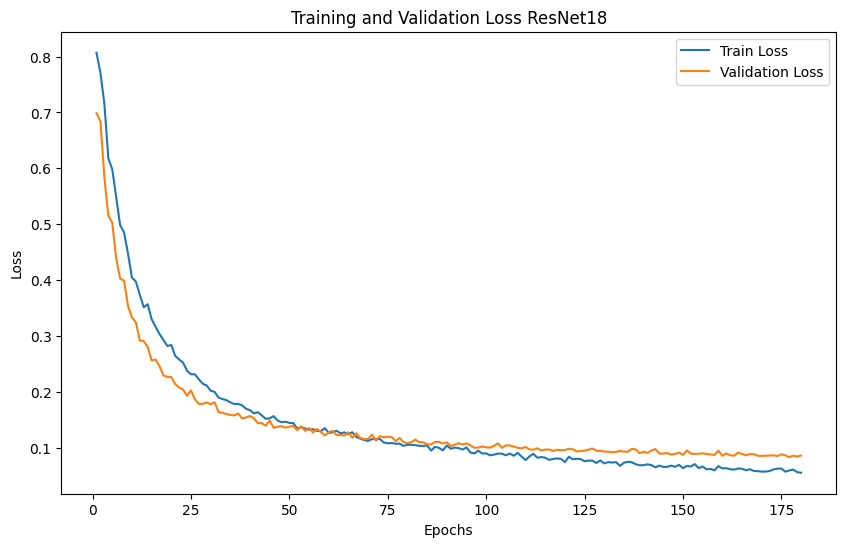

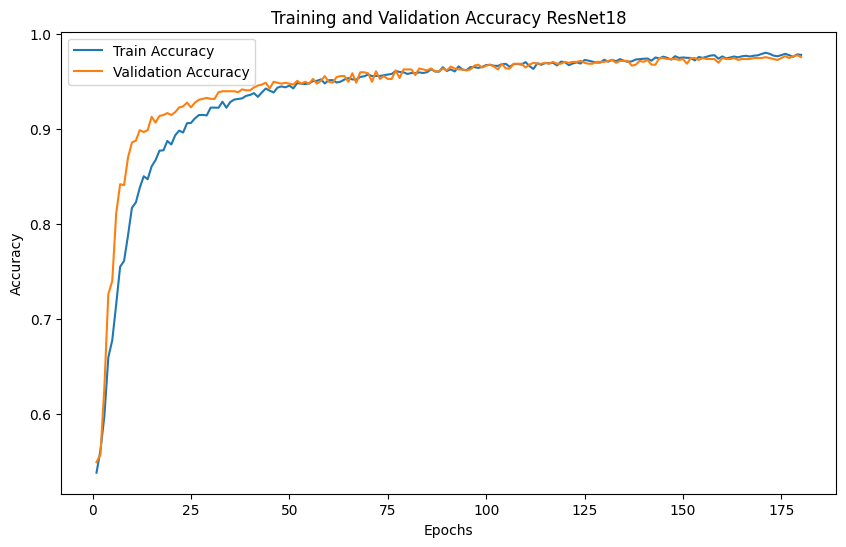

In [18]:
run(model, train_loader, val_loader, optimizer, criterion, device, scheduler)

# 5. Tạo file kiểm thử CSV

In [19]:
test_dir = '/kaggle/working/gender_data/Dataset/Test'

# Tải model
model_gender = models.resnet18(pretrained=False) 
model_gender.fc = nn.Sequential(
    nn.Dropout(0.5), 
    nn.Linear(model_gender.fc.in_features, 2)
)

# Gắn trọng số đã huấn luyện
model_gender.load_state_dict(torch.load("best_model.pth"))
model_gender.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
results = []
test_dir = "/kaggle/working/gender_data/Dataset/Test"

# Chạy với tập kiểm thử
for filename in os.listdir(test_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_dir, filename)
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0)

        with torch.no_grad():
            output = model_gender(input_tensor)
            pred = 1 - torch.argmax(output, dim=1).item()

        img_id = os.path.splitext(filename)[0]
        results.append({"ID": img_id, "Label": pred})

# Lưu CSV
df = pd.DataFrame(results)
df = df.sort_values(by="ID") # Xếp theo thứ tự ID
df.to_csv("submission.csv", index=False)

print("Done!")

Done!
